# Notes about simulation:

# Import packages and set settings

In [1]:
import sys
sys.path.insert(1, '../../python_modules')
import plotting
import model_supp 
import model
import saving

In [2]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

# import pathlib
import seaborn as sns
import matplotlib.pyplot as plt
# import pickle
import numpy as np
# import math
import pandas as pd
from scipy.integrate import odeint
# from scipy.integrate import solve_ivp
# import os
import itertools
from scipy.optimize import fsolve

In [3]:
# plt.style.use("seaborn-whitegrid")
plt.rcParams['figure.figsize'] = [10.0, 8.0]
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['grid.linestyle'] = '-'
plt.rcParams['legend.fontsize'] = 14
colors = [i['color'] for i in plt.rcParams['axes.prop_cycle']]

# Load experimental data

In [5]:
wt_folder = 'C:/Users/sksuzuki/Desktop/killdevil/data/MAPK activation/WT'
t100a_folder = 'C:/Users/sksuzuki/Desktop/killdevil/data/MAPK activation/T100A'
pbs2_folder = 'C:/Users/sksuzuki/Desktop/killdevil/data/MAPK activation/Pbs2'
pbs2_t100a_folder = 'C:/Users/sksuzuki/Desktop/killdevil/data/MAPK activation/Pbs2_T100A'
# sho1DD_folder = 'C:/Users/sksuzuki/Desktop/killdevil/data/MAPK activation/sho1DD'
# ssk1D_folder = 'C:/Users/sksuzuki/Desktop/killdevil/data/MAPK activation/ssk1D'
hog1_ramp_folder =  'C:/Users/sksuzuki/Desktop/killdevil/data/MAPK activation/ramp_1'
# pbs2_ramp_folder =  'C:/Users/sksuzuki/Desktop/killdevil/data_pbs2/MAPK activation/pulse_pbs2'
ptpD_folder = 'C:/Users/sksuzuki/Desktop/killdevil/data/MAPK activation/ptpD'

mapk_time, mapk_wt_data = model_supp.load_csv_data(wt_folder)
mapk_time, mapk_t100a_data = model_supp.load_csv_data(t100a_folder)
mapk_data_t100a_long = [mapk_t100a_data[0]] 
mapk_time_t100a_long = [0, 2, 5, 10, 15, 20, 25, 30, 60, 90, 120, 150, 180, 240, 300]

mapk_time, map2k_wt_data = model_supp.load_csv_data(pbs2_folder)
mapk_time, map2k_t100a_data = model_supp.load_csv_data(pbs2_t100a_folder)
mapk_time, mapk_ptp_data = model_supp.load_csv_data(ptpD_folder)
# mapk_time, sho1_wt_data = load_csv_data(ssk1D_folder)
# mapk_time, sln1_wt_data = load_csv_data(sho1DD_folder)
mapk_ramp_time, hog1_ramp_data = model_supp.load_csv_data(hog1_ramp_folder)
# mapk_pulse_time, pbs2_pulse_data = load_csv_data(pbs2_pulse_folder)

# hog1_pulse_data = hog1_pulse_data[0]
# pbs2_pulse_data = pbs2_pulse_data[0]

# exclude far points
mapk_t100a_data = [mapk_t100a_data[0][:9]] + mapk_t100a_data[1:]

# Model Variables (Constants)

In [25]:
dt = 0.1
steps = 601
time = np.linspace(0,dt*steps,steps)

gen = 1000
runs = 2000

MAP3K_t = model_supp.molarity_conversion(701)
MAP2K_t = model_supp.molarity_conversion(2282)
MAPK_t = model_supp.molarity_conversion(5984)
PTP_t = model_supp.molarity_conversion(118+400)

MAP3K = 0.05*MAP3K_t # estimated (so not 0)
MAP2K = 0.05975380333*MAP2K_t # from the biological data
MAPK = 0.00540042381*MAPK_t  # from the biological data
gly = 0.00001 # placeholder (so not 0)
PTP = model_supp.molarity_conversion(118+400) # start with all on

PTP = model_supp.molarity_conversion(118+400)


labelnames = ['$- fb_1$', '$kb$',
              '$k_1$', '$k_3$', '$k_5$', '$s_1$',
              '$k_2$', '$k_4$', '$k_6$', '$d_1$',
              '$K_{M1}$', '$K_{M3}$', '$K_{M5}$',
              '$K_{M2}$', '$K_{M4}$', '$K_{M6}$']


minimums = [-4, -4,
        -4, -4, -4, -4,
        -4, -4, -4, -4, 
        -4, -4, -4, 
        -4, -4, -4]

maximums = [ 4, 4, 
        4, 4, 4, 4,
        4, 4, 4, 4, 
        4, 4, 4,
        4, 4, 4]

diff = np.asarray(maximums)-np.asarray(minimums)
dims = (diff, minimums)


initials = [MAP3K, MAP2K, MAPK, gly]
params_constants = [MAP3K_t, MAP2K_t, MAPK_t, 1] 


doses = [0, 50000, 150000, 250000, 350000, 450000, 550000]
map2k_doses = [150000, 550000]

# M2

## M2 - fit to all Hog1 and Pbs2 data

**Notes** 

### Inputs

In [97]:
folder = 'C:/Users/sksuzuki/Desktop/killdevil/runs_for_paper/190924_kb_M2/'

# mapk_time_t100a_long = [0, 2, 5, 10, 15, 20, 25, 30, 60, 90, 120, 150, 180, 240, 300]

M2_fxns = model.Model(model.M2, model.simulate_t100a_experiment_M2)

model_folder = 'M2/'
sim_id = 'M2_f-all_'

In [7]:
if len(labelnames) == len(diff):
    print('Params and labels match')

Params and labels match


### Gather simulated data

In [9]:
idx_top_M2_all, top_params_M2_all, top, plt_top, new_params, params_from_file, mse_M2_all, last_mses_M2_all = model_supp.gather_simulated_data(folder, gen, runs, 0.01)
df_top_params = pd.DataFrame(top_params_M2_all)
df_top_params.columns = labelnames
df_top_params_log = df_top_params.apply(np.log10)
df_top_params_log_M_M2_all = df_top_params_log.melt(var_name='param', value_name='vals')

Number of runs collected: 1807
Best MSE: 3084.505466527344
Mean MSE of top 5%: 3320.6341817328816


### Plot

In [10]:
select_top_M2_all = top_params_M2_all.copy()
# select_top_M2_all = np.concatenate((select_top_[:7], select_top_M4[8:11]))

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

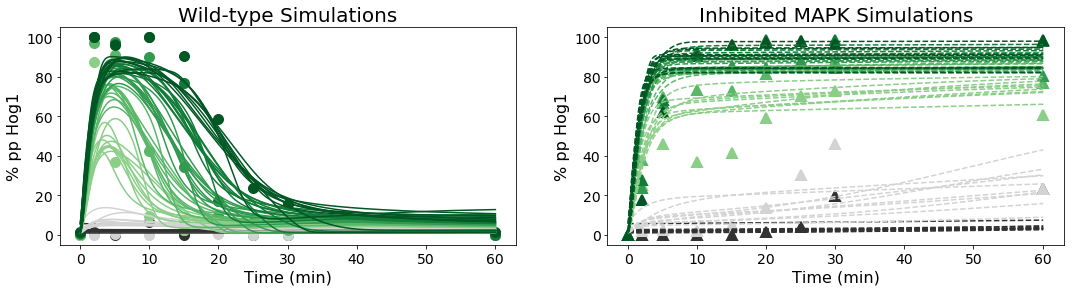

In [141]:
plotting.plt_param_behaviors(M2_fxns, select_top_M2_all, 10, params_constants, initials,  doses, time, 2, mapk_wt_data, mapk_t100a_data, mapk_time, save_fig=model_folder+sim_id+'hog1')
# plt.savefig("C:/Users/sksuzuki/Documents/Research/figures/simulations/hog1.png",dpi=150,bbox_inches='tight')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

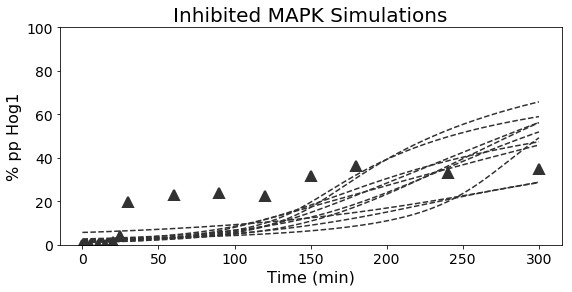

In [99]:
mapk_time_t100a_long = [0, 2, 5, 10, 15, 20, 25, 30, 60, 90, 120, 150, 180, 240, 300]

plotting.plt_t100a_long(M2_fxns, select_top_M2_all, 10, params_constants, initials, mapk_data_t100a_long[0], mapk_time_t100a_long, save_fig=model_folder+sim_id+'t100a_long')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

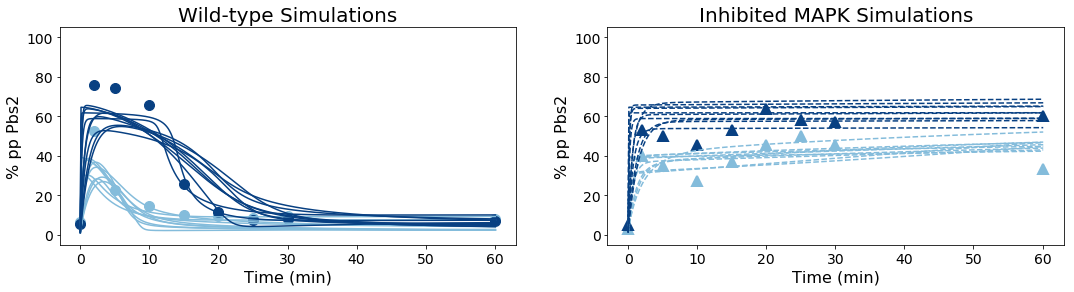

In [100]:
plotting.plt_param_behaviors(M2_fxns, select_top_M2_all, 10, params_constants, initials,  map2k_doses, time, 1, map2k_wt_data, map2k_t100a_data, mapk_time, save_fig=model_folder+sim_id+'pbs2')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

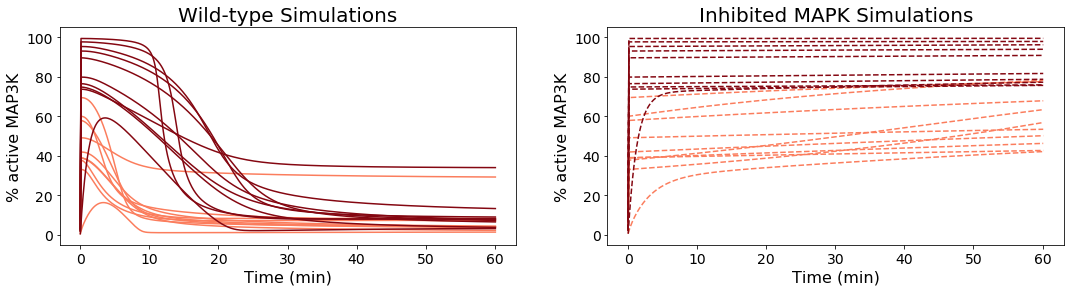

In [101]:
plotting.plt_param_behaviors(M2_fxns, top_params_M2_all, 10, params_constants, initials,  map2k_doses, time, 0, save_fig=model_folder+sim_id+'MAP3K')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

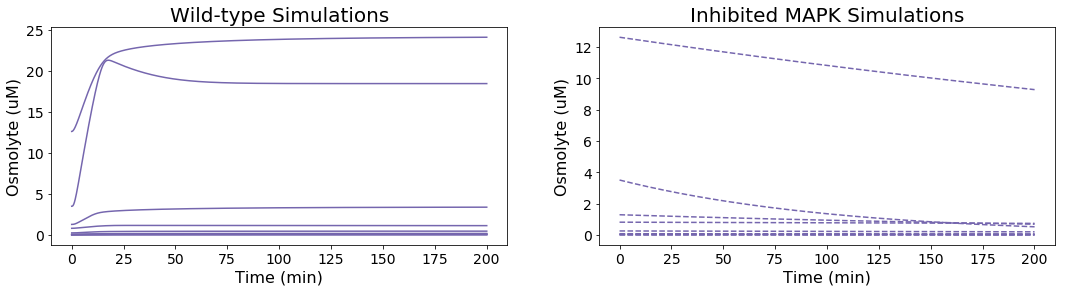

In [110]:
plotting.plt_param_behaviors(M2_fxns, top_params_M2_all, 10, params_constants, initials,  [350000], time, 3, save_fig=model_folder+sim_id+'Osmolytes')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


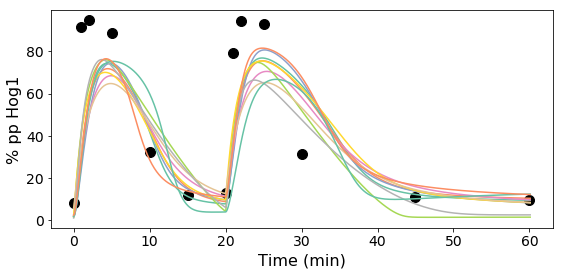

In [127]:
plotting.plt_ramp_behaviors(M2_fxns, top_params_M2_all, 10, params_constants, initials, time, 2, hog1_ramp_data, mapk_ramp_time, save_fig=model_folder+sim_id+'ramp')

<Figure size 720x576 with 0 Axes>

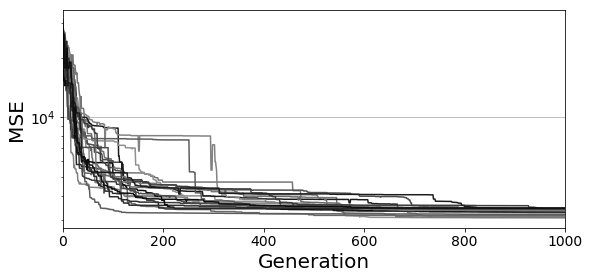

In [129]:
plotting.plt_mses_gen(gen,mse_M2_all, idx_top_M2_all, save_fig=model_folder+sim_id+'mses')

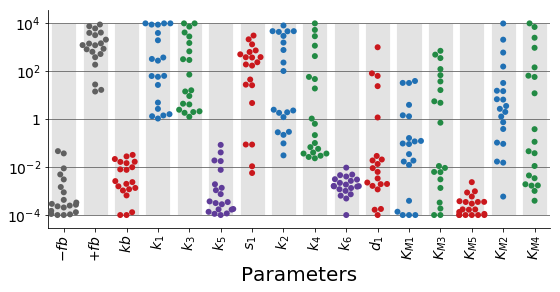

In [130]:
plotting.plt_param_ranges(labelnames, 'M2', dims, df_top_params_log_M_M2_all, save_fig=model_folder+sim_id+'params')

In [134]:
mses_M2_all = model_supp.get_mse_stats(M2_fxns, top_params_M2_all, params_constants, initials, ptpD=False)
mses_M2_all.head()

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


0          1           2           3           4           5   \
0  5.164534  16.407590  214.894542  226.107767  270.250703  287.826122   
1  5.050774  22.950741  271.389663  246.362646  257.400781  267.032250   
2  4.854047  14.070178  352.142131  297.490928  271.209524  257.432920   
3  6.322193  25.658479  331.148133  332.448746  339.523042  349.362463   
4  4.356977  12.518387  385.656737  203.217303  230.559185  261.858571   

           6           7           8           9           10          11  \
0  237.714403  145.905577  155.326124  350.271645   78.013100  193.624424   
1  194.848824  100.674772  137.291484  274.898422   81.971381  229.409039   
2  183.516515  173.050839  213.080849  165.852574   75.264033  197.667800   
3  264.116575  141.756747  166.618532  188.546445   65.570064  181.582911   
4  213.458922  152.311854  153.582011  307.818765  117.879859  221.341433   

           12          13          14         15          16          17  
0  209.744330  328.756572  222.104449  52.576474   28.138034  820.625200  
1  259.146845  413.363823   96.660752  56.526666  133.967221  751.242041  
2  218.981595  368.132781  172.501978  47.775273   56.024432  944.637608  
3  164.805641  302.383327  101.714531  50.559683  101.673226  899.570237  
4  286.426791  393.589415   47.240782  69.829821   66.315663  585.527968

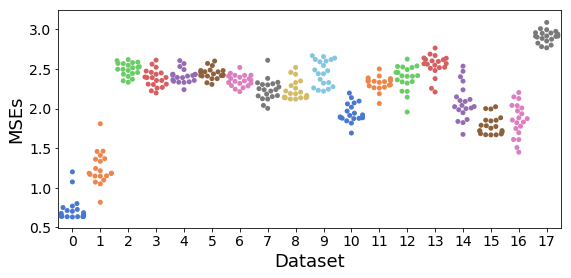

In [136]:
plotting.plt_mses_swarm(mses_M2_all, save_fig='')

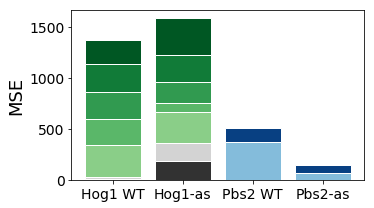

In [138]:
plotting.plt_mses(mses_M2_all, (1,1, 1, 1, 0,0), size=(5,3), ptpD=False ,save_fig=model_folder+sim_id+'fit_mses')

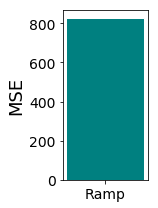

In [140]:
plotting.plt_mses(mses_M2_all, (0,0, 0, 0, 1, 1), size=(2,3), ptpD=False ,save_fig=model_folder+sim_id+'predicted_mses')

$+ fb$    $k_5$       0.605463
$k_5$     $+ fb$      0.605463
$- fb$    $s_1$       0.629005
$s_1$     $- fb$      0.629005
$k_6$     $k_2$       0.792034
$k_2$     $k_6$       0.792034
          $K_{M2}$    0.814501
$K_{M2}$  $k_2$       0.814501
$k_1$     $kb$        0.827684
$kb$      $k_1$       0.827684
dtype: float64


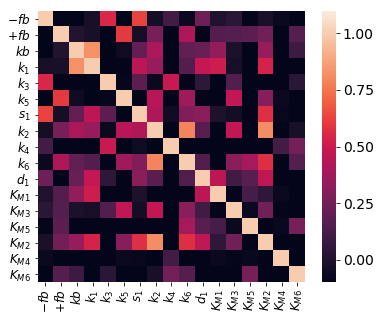

In [131]:
plotting.plt_corr(labelnames, df_top_params, save_fig=model_folder+sim_id+'corr')

### Save data 

In [141]:
# save_sim_data(select_top_M4, doses, 2, path='C:/Users/sksuzuki/Documents/Research/figures/paper1/unsorted/', sim_name='M4_wt')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [143]:
# save_sim_data(select_top_M4, doses, 2, path='C:/Users/sksuzuki/Documents/Research/figures/paper1/unsorted/', sim_name='M4_t100a', t100a=True)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [151]:
# save_sim_data(select_top_M4, doses, 2, path='C:/Users/sksuzuki/Documents/Research/figures/paper1/unsorted/', sim_name='M4_ramp', ramp=True)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


# M2a

## Model Constant Params

In [268]:
folder = 'C:/Users/sksuzuki/Desktop/killdevil/runs_for_paper/191004_kb_M2a_hog1/'

gen = 500
runs = 2000


labelnames = ['$- fb$', '$+ fb$', '$kb$',
              '$k_1$', '$k_3$', '$k_5$', '$s_1$',
              '$k_2$', '$k_4$', '$k_6$', '$d_1$',
              '$K_{M1}$', '$K_{M3}$', '$K_{M5}$',
              '$K_{M2}$', '$K_{M4}$', '$K_{M6}$']


minimums = [-4, -4, -4,
        -4, -4, -4, -4,
        -4, -4, -4, -4, 
        -4, -4, -4, 
        -4, -4, -4]

maximums = [ 4, 4, 4, 
        4, 4, 4, 4,
        4, 4, 4, 4, 
        4, 4, 4,
        4, 4, 4]

diff = np.asarray(maximums)-np.asarray(minimums)
dims = (diff, minimums)


M2a_fxns = model.Model(model.M2a, model.simulate_t100a_experiment_M2a)



##  191004_kb_M2a_hog1.py

**Notes** 

### Inputs

In [269]:
folder = 'C:/Users/sksuzuki/Desktop/killdevil/runs_for_paper/191004_kb_M2a_hog1/'

model_folder = 'M2a/'
sim_id = 'M2a_f-hog1_'

### Gather simulated data

In [270]:
idx_top_M2a_hog1, top_params_M2a_hog1, top, plt_top, new_params, params_from_file, mse_M2a_hog1, last_mses_M2a_hog1 = model_supp.gather_simulated_data(folder, gen, runs, 0.01)
df_top_params = pd.DataFrame(top_params_M2a_hog1)
df_top_params.columns = labelnames
df_top_params_log = df_top_params.apply(np.log10)
df_top_params_log_M_M2a_hog1 = df_top_params_log.melt(var_name='param', value_name='vals')

Number of runs collected: 1998
Best MSE: 2064.397976882752
Mean MSE of top 5%: 2671.005999626424


### Plot

In [ ]:
select_top_M2a_hog1 = top_params_M2a_hog1.copy()
# select_top_M2_all = np.concatenate((select_top_[:7], select_top_M4[8:11]))

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


<Figure size 720x576 with 0 Axes>

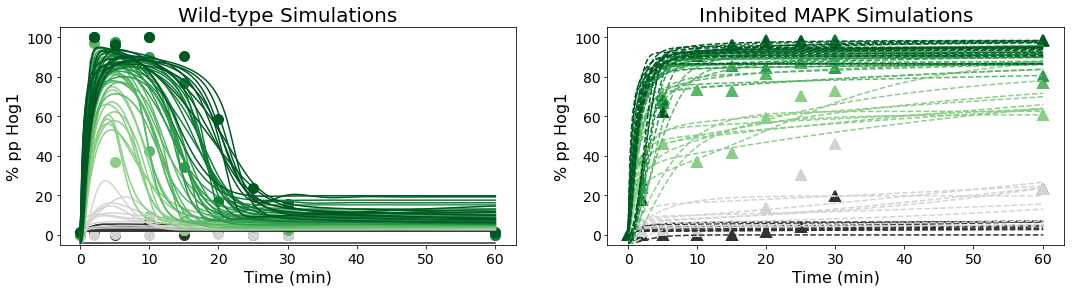

In [147]:
plotting.plt_param_behaviors(M2a_fxns, select_top_M2a_hog1, 10, params_constants, initials,  doses, time, 2, mapk_wt_data, mapk_t100a_data, mapk_time)# save_fig=model_folder+sim_id+'hog1')
# plt.savefig("C:/Users/sksuzuki/Documents/Research/figures/simulations/hog1.png",dpi=150,bbox_inches='tight')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

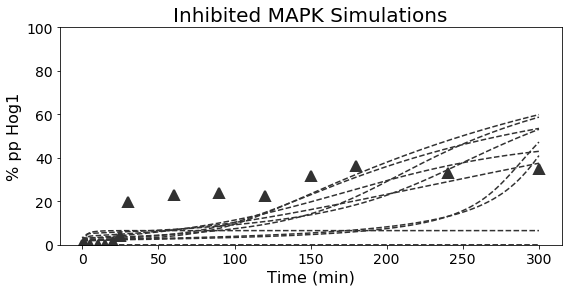

In [148]:
mapk_time_t100a_long = [0, 2, 5, 10, 15, 20, 25, 30, 60, 90, 120, 150, 180, 240, 300]

plotting.plt_t100a_long(M2a_fxns, select_top_M2a_hog1, 10, params_constants, initials, mapk_data_t100a_long[0], mapk_time_t100a_long, save_fig=model_folder+sim_id+'t100a_long')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

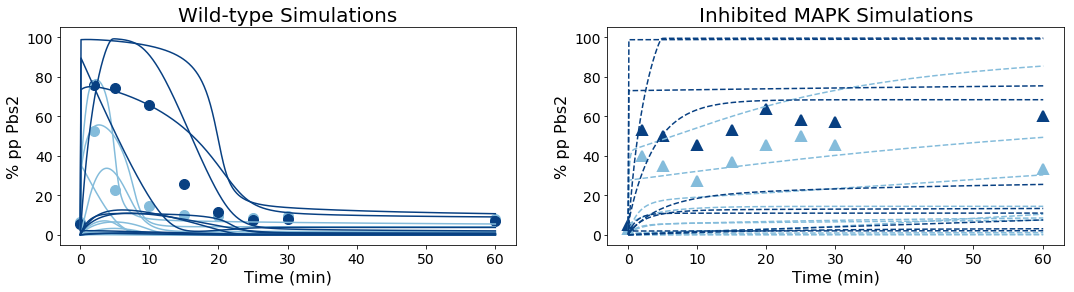

In [149]:
plotting.plt_param_behaviors(M2a_fxns, select_top_M2a_hog1, 10, params_constants, initials,  map2k_doses, time, 1, map2k_wt_data, map2k_t100a_data, mapk_time, save_fig=model_folder+sim_id+'pbs2')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

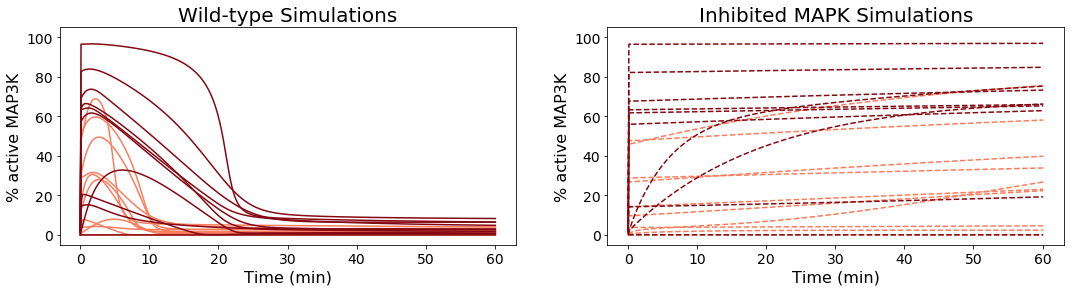

In [150]:
plotting.plt_param_behaviors(M2a_fxns, select_top_M2a_hog1, 10, params_constants, initials,  map2k_doses, time, 0, save_fig=model_folder+sim_id+'MAP3K')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

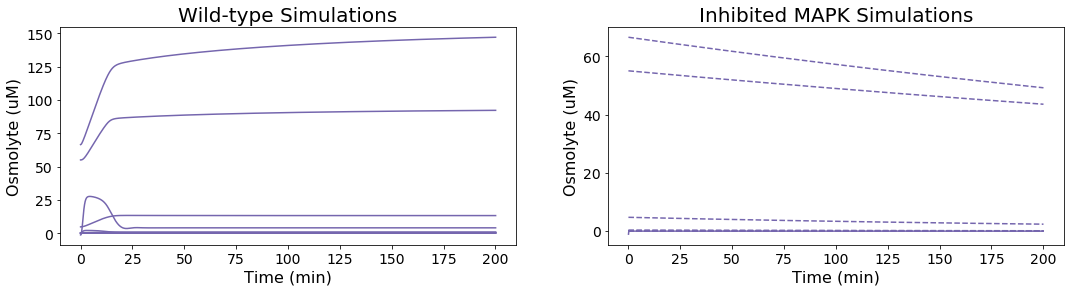

In [151]:
plotting.plt_param_behaviors(M2a_fxns, select_top_M2a_hog1, 10, params_constants, initials,  [350000], time, 3, save_fig=model_folder+sim_id+'Osmolytes')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


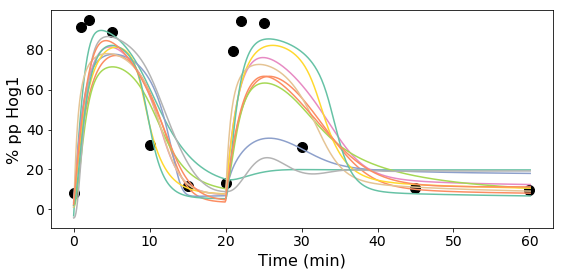

In [153]:
plotting.plt_ramp_behaviors(M2a_fxns, select_top_M2a_hog1, 10, params_constants, initials, time, 2, hog1_ramp_data, mapk_ramp_time, save_fig=model_folder+sim_id+'ramp')

<Figure size 720x576 with 0 Axes>

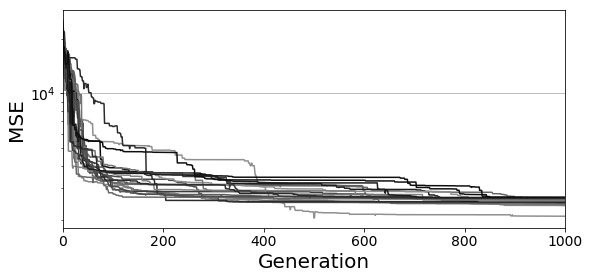

In [157]:
plotting.plt_mses_gen(gen,mse_M2a_hog1, idx_top_M2a_hog1, save_fig=model_folder+sim_id+'mses')

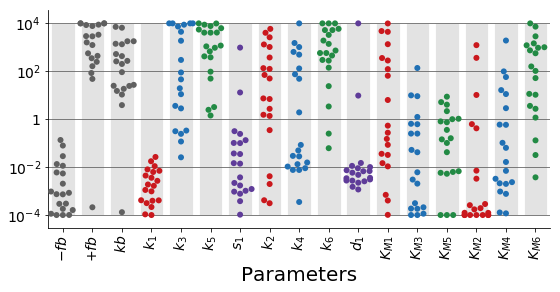

In [158]:
plotting.plt_param_ranges(labelnames, 'M2a', dims, df_top_params_log_M_M2a_hog1, save_fig=model_folder+sim_id+'params')

In [159]:
mses_M2a_hog1 = model_supp.get_mse_stats(M2a_fxns, top_params_M2a_hog1, params_constants, initials, ptpD=False)
mses_M2a_hog1.head()

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


0          1           2           3           4           5   \
0  10.765624  37.476815  293.622026  158.617947  106.277928  240.329715   
1   5.048706  43.138014  303.933184  240.189604  209.185351  212.921432   
2  11.386376  48.706711  297.652704  197.461525  126.523256  100.464337   
3   8.954262  27.367811  276.468743  157.174058  148.120653  171.101136   
4   7.731780  63.278288  342.737440  285.674363  234.473122  195.077743   

           6           7           8           9           10          11  \
0  391.786342  278.677630  152.943539  124.295320  144.080422   40.462529   
1  201.029076  128.263850  146.743746  127.108472   49.879000  192.799032   
2  114.859838   76.042529  180.511229  123.370376   63.339458  265.868184   
3  126.471031  151.350634  236.907830  127.419146   64.440228  251.800686   
4  135.459412   91.620759  158.274410  117.791067   48.509324  226.142665   

           12          13           14           15           16           17  
0   25.558704  104.464561   369.042715   642.156022   145.847222  1473.267984  
1  198.049102  353.823629  1368.554175  1021.933333  1683.172009   861.754291  
2  306.599925  539.429439  1317.299773  1187.241127  1170.565493  1192.245394  
3  269.111718  456.327173   162.250577    77.716164   337.795141   588.403278  
4  208.397014  380.654253  1796.851432  1395.957004  2438.028928   986.159309

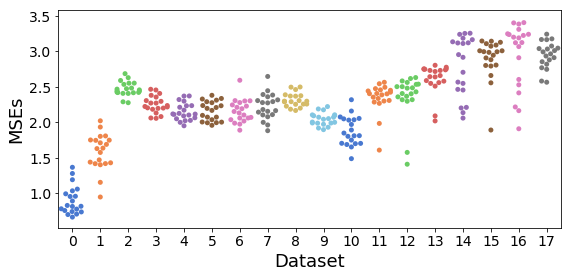

In [160]:
plotting.plt_mses_swarm(mses_M2a_hog1, save_fig='')

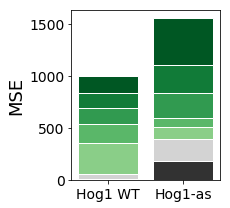

In [162]:
plotting.plt_mses(mses_M2a_hog1, (1,1, 0, 0, 0,0), size=(3,3), ptpD=False ,save_fig=model_folder+sim_id+'fit_mses')

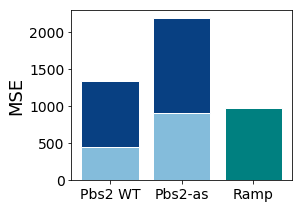

In [164]:
plotting.plt_mses(mses_M2a_hog1, (0,0, 1, 1, 1, 1), size=(4,3), ptpD=False ,save_fig=model_folder+sim_id+'predicted_mses')

$K_{M3}$  $K_{M5}$    0.764502
$K_{M5}$  $K_{M3}$    0.764502
$k_1$     $+ fb$      0.797651
$+ fb$    $k_1$       0.797651
$k_2$     $K_{M2}$    0.808016
$K_{M2}$  $k_2$       0.808016
$k_1$     $kb$        0.949675
$kb$      $k_1$       0.949675
$s_1$     $d_1$       0.999923
$d_1$     $s_1$       0.999923
dtype: float64


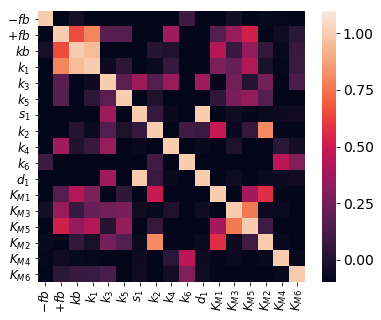

In [165]:
plotting.plt_corr(labelnames, df_top_params, save_fig=model_folder+sim_id+'corr')

##  191004_kb_M2a_hog1.py

**Notes** 

### Inputs

In [206]:
folder = 'C:/Users/sksuzuki/Desktop/killdevil/runs_for_paper/191014_kb_M2a/'

model_folder = 'M2a/'
sim_id = 'M2a_f-all_'

### Gather simulated data

In [207]:
idx_top_M2a_all, top_params_M2a_all, top, plt_top, new_params, params_from_file, mse_M2a_all, last_mses_M2a_all = model_supp.gather_simulated_data(folder, gen, runs, 0.01)
df_top_params = pd.DataFrame(top_params_M2a_all)
df_top_params.columns = labelnames
df_top_params_log = df_top_params.apply(np.log10)
df_top_params_log_M_M2a_all = df_top_params_log.melt(var_name='param', value_name='vals')

Number of runs collected: 930
Best MSE: 2877.4083278395465
Mean MSE of top 5%: 3269.0162836888385


### Plot

In [208]:
select_top_M2a_all = top_params_M2a_all.copy()
# select_top_M2_all = np.concatenate((select_top_[:7], select_top_M4[8:11]))

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

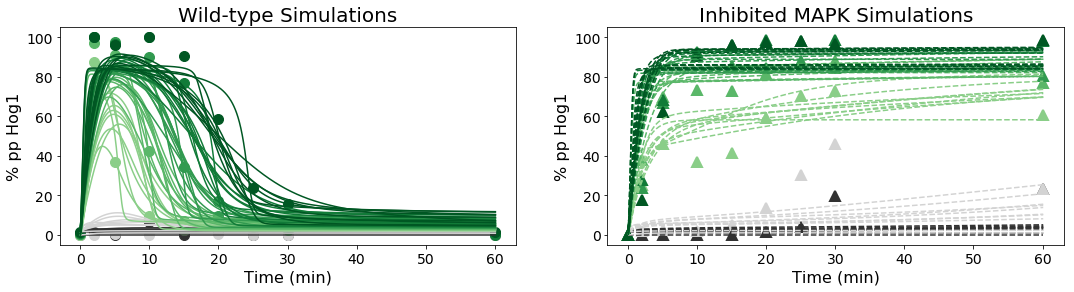

In [209]:
plotting.plt_param_behaviors(M2a_fxns, select_top_M2a_all, 10, params_constants, initials,  doses, time, 2, mapk_wt_data, mapk_t100a_data, mapk_time, save_fig=model_folder+sim_id+'hog1')
# plt.savefig("C:/Users/sksuzuki/Documents/Research/figures/simulations/hog1.png",dpi=150,bbox_inches='tight')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

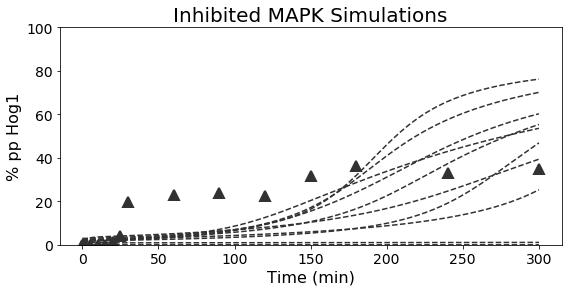

In [210]:
mapk_time_t100a_long = [0, 2, 5, 10, 15, 20, 25, 30, 60, 90, 120, 150, 180, 240, 300]

plotting.plt_t100a_long(M2a_fxns, select_top_M2a_all, 10, params_constants, initials, mapk_data_t100a_long[0], mapk_time_t100a_long, save_fig=model_folder+sim_id+'t100a_long')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

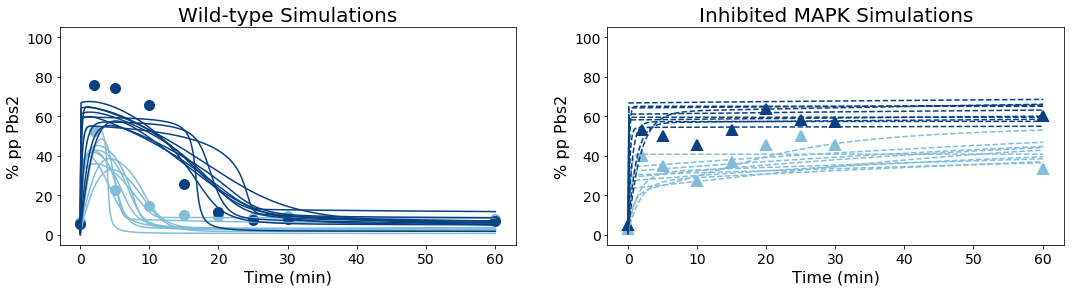

In [211]:
plotting.plt_param_behaviors(M2a_fxns, select_top_M2a_all, 10, params_constants, initials,  map2k_doses, time, 1, map2k_wt_data, map2k_t100a_data, mapk_time, save_fig=model_folder+sim_id+'pbs2')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

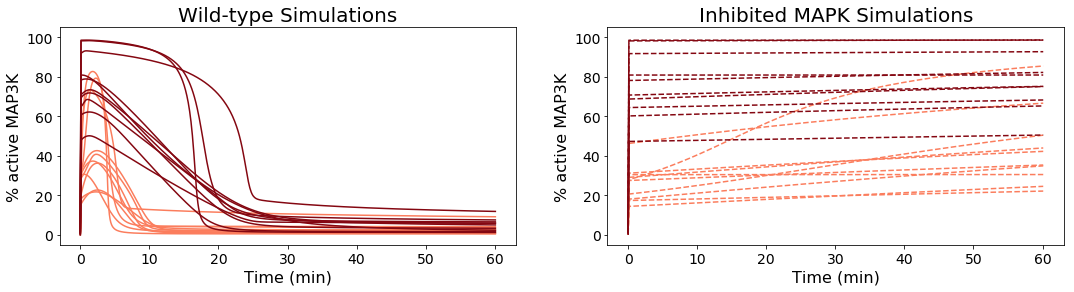

In [212]:
plotting.plt_param_behaviors(M2a_fxns, select_top_M2a_all, 10, params_constants, initials,  map2k_doses, time, 0, save_fig=model_folder+sim_id+'MAP3K')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

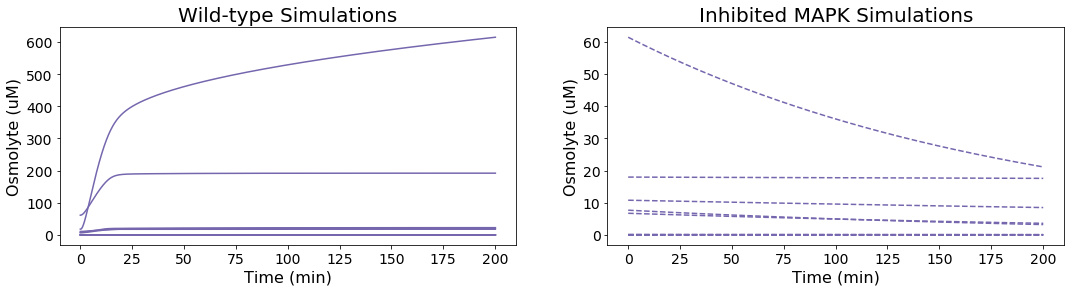

In [213]:
plotting.plt_param_behaviors(M2a_fxns, select_top_M2a_all, 10, params_constants, initials,  [350000], time, 3, save_fig=model_folder+sim_id+'Osmolytes')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


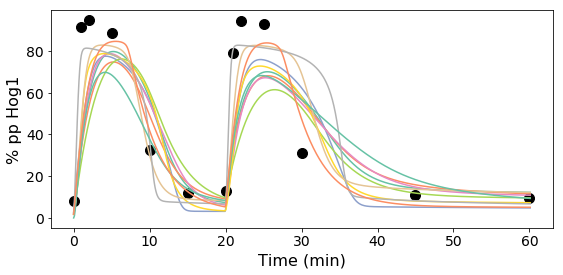

In [215]:
plotting.plt_ramp_behaviors(M2a_fxns, select_top_M2a_all, 10, params_constants, initials, time, 2, hog1_ramp_data, mapk_ramp_time, save_fig=model_folder+sim_id+'ramp')

<Figure size 720x576 with 0 Axes>

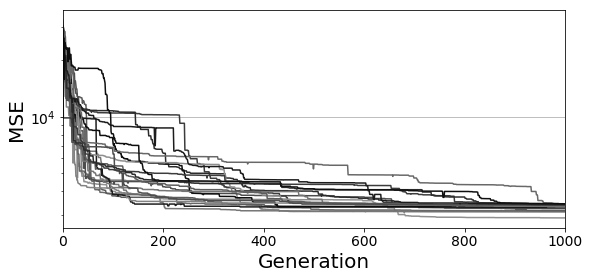

In [218]:
plotting.plt_mses_gen(gen,mse_M2a_all, idx_top_M2a_all, save_fig=model_folder+sim_id+'mses')

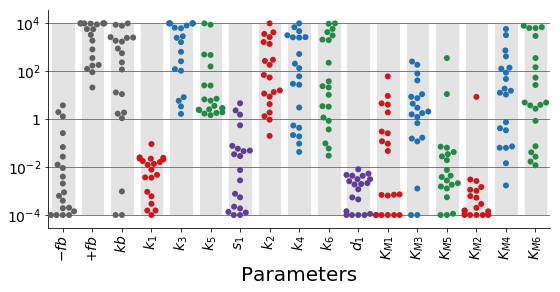

In [219]:
plotting.plt_param_ranges(labelnames, 'M2a', dims, df_top_params_log_M_M2a_all, save_fig=model_folder+sim_id+'params')

In [220]:
mses_M2a_all = model_supp.get_mse_stats(M2a_fxns, top_params_M2a_all, params_constants, initials, ptpD=False)
mses_M2a_all.head()

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)


0          1           2           3           4           5   \
0     6.632722  22.985335  320.363401  214.776401  204.079035  231.954426   
1     4.964836  15.027797  309.254775  262.067818  276.937627  308.430213   
2  6649.622013  16.348407  302.080128  168.319070  152.595746  149.478993   
3     5.533151  33.681767  342.544075  202.948407  179.487601  213.359248   
4     8.106650  28.873037  440.506346  388.776881  330.536015  332.237743   

           6           7           8           9          10          11  \
0  195.453955  167.820873  233.295853   94.079480  59.971838  218.587457   
1  254.409817  223.746266  259.747912  126.441095  72.731769  195.192556   
2  155.388939  216.940263  223.151417  128.462526  72.285923  276.620317   
3  167.163832  111.327950  154.814798  116.238579  56.530803  240.618985   
4  305.043229  144.846382  206.221145  107.251912  50.451441  128.019070   

           12          13          14          15          16           17  
0  217.035116  376.789631  109.181161   69.431389   64.711957   788.507958  
1  175.152894  312.033056   91.500376   52.040483  108.638521   851.191585  
2  385.809457  556.300668  147.185016   87.098960   36.179918   659.407213  
3  283.175393  476.592952  204.491620  143.495687   79.619501   851.690243  
4  116.763646  235.561085   48.698567   55.892653  159.554248  1163.623708

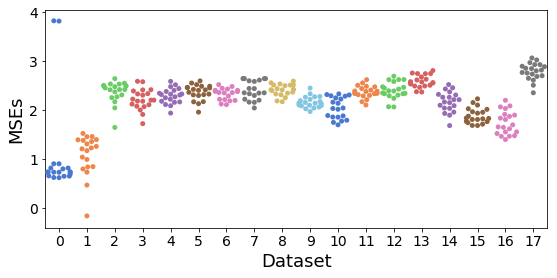

In [221]:
plotting.plt_mses_swarm(mses_M2a_all, save_fig='')

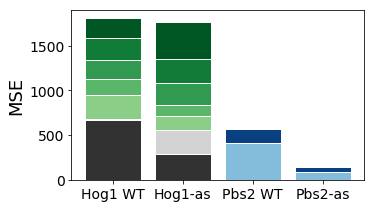

In [223]:
plotting.plt_mses(mses_M2a_all, (1,1, 1, 1, 0,0), size=(5,3), ptpD=False ,save_fig=model_folder+sim_id+'fit_mses')

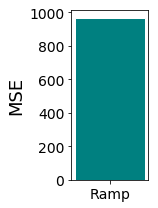

In [225]:
plotting.plt_mses(mses_M2a_hog1, (0,0, 0, 0, 1, 1), size=(2,3), ptpD=False ,save_fig=model_folder+sim_id+'predicted_mses')

$K_{M4}$  $s_1$       0.711170
$s_1$     $K_{M4}$    0.711170
$kb$      $k_1$       0.722318
$k_1$     $kb$        0.722318
$K_{M2}$  $k_2$       0.847272
$k_2$     $K_{M2}$    0.847272
$K_{M1}$  $K_{M5}$    0.983845
$K_{M5}$  $K_{M1}$    0.983845
$s_1$     $- fb$      0.998717
$- fb$    $s_1$       0.998717
dtype: float64


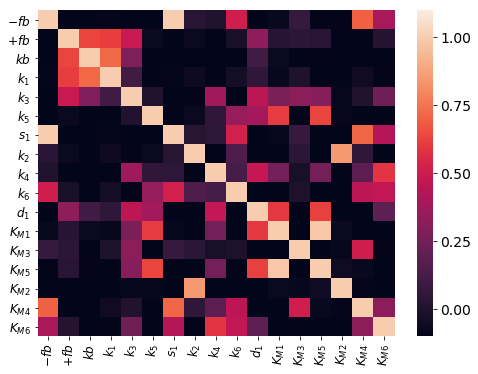

In [226]:
plotting.plt_corr(labelnames, df_top_params, save_fig=model_folder+sim_id+'corr')

# M2b

##  191004_kb_M2b_hog1.py

**Notes** 

### Inputs

In [167]:
folder = 'C:/Users/sksuzuki/Desktop/killdevil/runs_for_paper/191004_kb_M2b_hog1/'

diff = np.asarray(maximums)-np.asarray(minimums)
dims = (diff, minimums)


M2b_fxns = model.Model(model.M2b, model.simulate_t100a_experiment_M2a)

model_folder = 'M2b/'
sim_id = 'M2b_f-hog1_'

### Gather simulated data

In [169]:
idx_top_M2b_hog1, top_params_M2b_hog1, top, plt_top, new_params, params_from_file, mse_M2b_hog1, last_mses_M2b_hog1 = model_supp.gather_simulated_data(folder, gen, runs, 0.01)
df_top_params = pd.DataFrame(top_params_M2b_hog1)
df_top_params.columns = labelnames
df_top_params_log = df_top_params.apply(np.log10)
df_top_params_log_M_M2b_hog1 = df_top_params_log.melt(var_name='param', value_name='vals')

Number of runs collected: 2000
Best MSE: 963.3687459551367
Mean MSE of top 5%: 1091.1427216945553


### Plot

In [170]:
select_top_M2b_hog1 = top_params_M2b_hog1.copy()
# select_top_M2_all = np.concatenate((select_top_[:7], select_top_M4[8:11]))

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

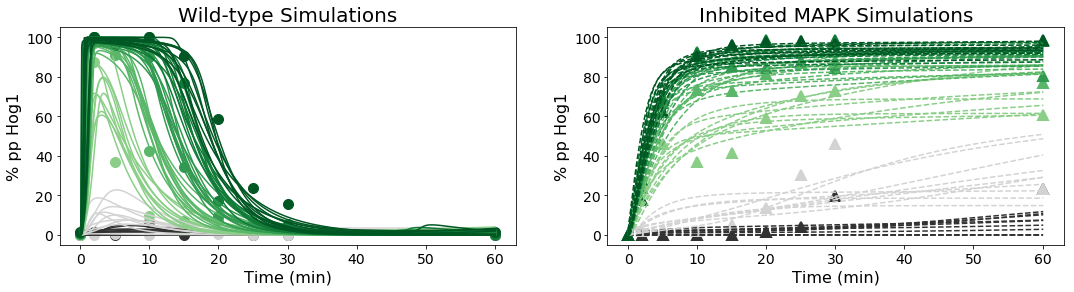

In [171]:
plotting.plt_param_behaviors(M2b_fxns, select_top_M2b_hog1, 10, params_constants, initials,  doses, time, 2, mapk_wt_data, mapk_t100a_data, mapk_time, save_fig=model_folder+sim_id+'hog1')
# plt.savefig("C:/Users/sksuzuki/Documents/Research/figures/simulations/hog1.png",dpi=150,bbox_inches='tight')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

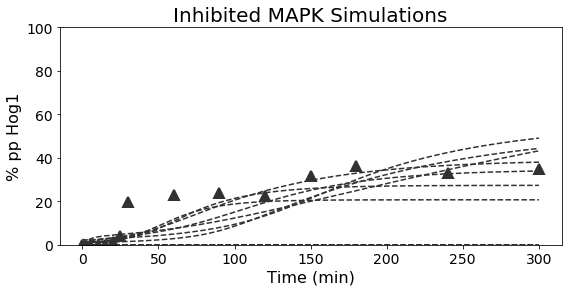

In [172]:
mapk_time_t100a_long = [0, 2, 5, 10, 15, 20, 25, 30, 60, 90, 120, 150, 180, 240, 300]

plotting.plt_t100a_long(M2b_fxns, select_top_M2b_hog1, 10, params_constants, initials, mapk_data_t100a_long[0], mapk_time_t100a_long, save_fig=model_folder+sim_id+'t100a_long')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

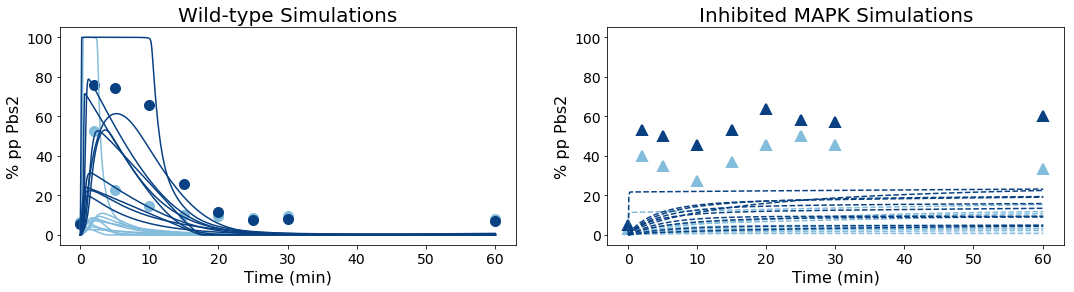

In [173]:
plotting.plt_param_behaviors(M2b_fxns, select_top_M2b_hog1, 10, params_constants, initials,  map2k_doses, time, 1, map2k_wt_data, map2k_t100a_data, mapk_time, save_fig=model_folder+sim_id+'pbs2')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

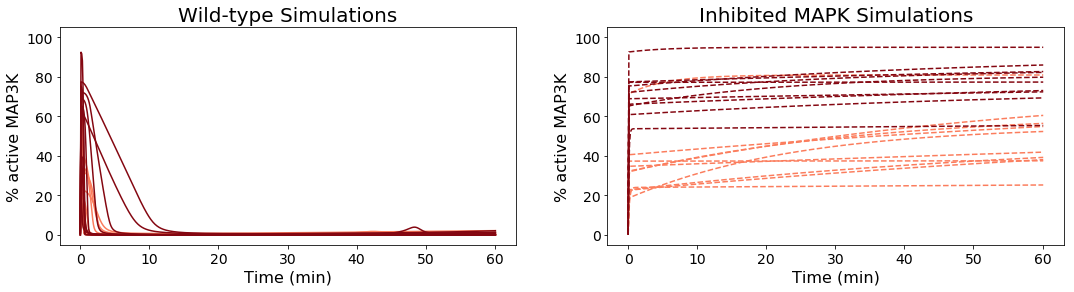

In [174]:
plotting.plt_param_behaviors(M2b_fxns, select_top_M2b_hog1, 10, params_constants, initials,  map2k_doses, time, 0, save_fig=model_folder+sim_id+'MAP3K')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

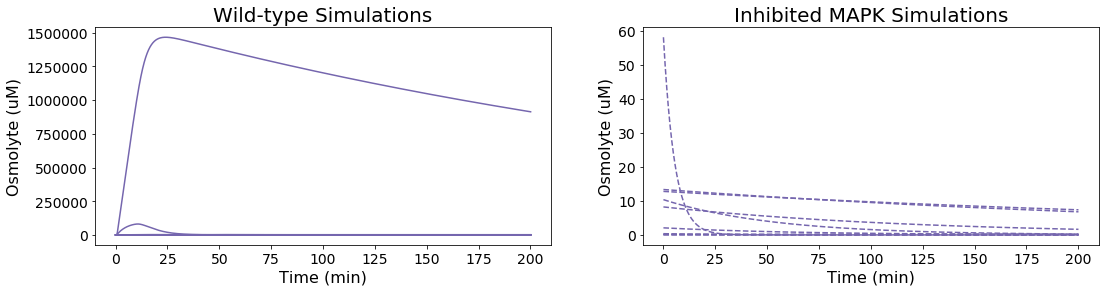

In [175]:
plotting.plt_param_behaviors(M2b_fxns, select_top_M2b_hog1, 10, params_constants, initials,  [350000], time, 3, save_fig=model_folder+sim_id+'Osmolytes')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


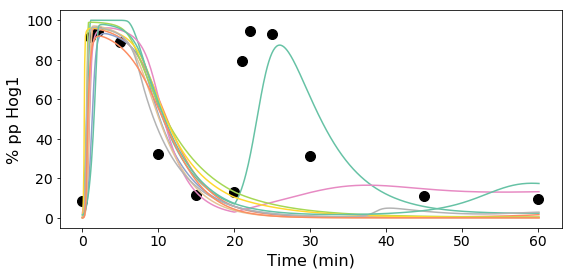

In [177]:
plotting.plt_ramp_behaviors(M2b_fxns, select_top_M2b_hog1, 10, params_constants, initials, time, 2, hog1_ramp_data, mapk_ramp_time, save_fig=model_folder+sim_id+'ramp')

<Figure size 720x576 with 0 Axes>

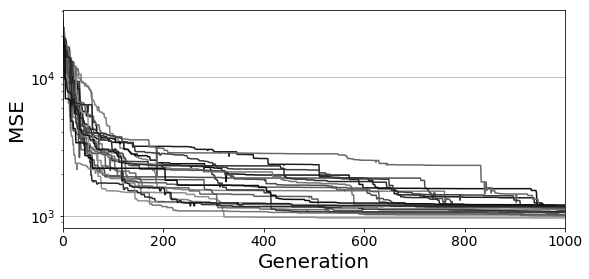

In [179]:
plotting.plt_mses_gen(gen,mse_M2b_hog1, idx_top_M2b_hog1, save_fig=model_folder+sim_id+'mses')

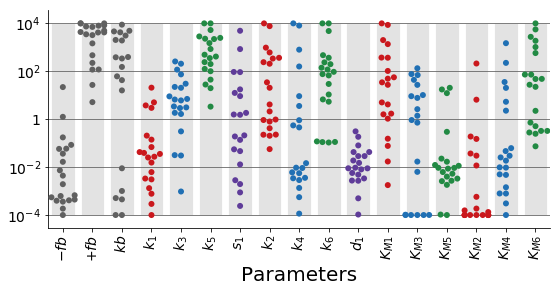

In [181]:
plotting.plt_param_ranges(labelnames, 'M2a', dims, df_top_params_log_M_M2b_hog1, save_fig=model_folder+sim_id+'params')

In [182]:
mses_M2b_hog1 = model_supp.get_mse_stats(M2b_fxns, top_params_M2b_hog1, params_constants, initials, ptpD=False)
mses_M2b_hog1.head()

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


0          1           2          3          4          5   \
0  4.584886  95.108608  166.826745  50.247878   4.669949  33.511965   
1  3.178082  10.013827  178.399208  61.657450  27.041793  22.317379   
2  3.381438  20.616014  218.108380  31.937675   8.277294  21.378175   
3  6.312922  21.212110  187.022886  49.589515   9.252366   8.547228   
4  3.736693  42.313652  123.327915  79.952090  29.129413  54.012925   

          6          7           8           9           10         11  \
0  36.702925  93.207760  135.101820   87.927315   75.648433  55.195152   
1  90.989412  77.098001  136.064597  144.530688   92.390684  31.899762   
2  76.377047  70.234626  134.975049  104.865500   38.598040  52.912259   
3  68.288347  33.863221  132.757761   95.575312   48.923178  62.018986   
4  77.866142  49.052484  142.934989  146.617079  140.706346  91.984237   

          12          13           14           15           16           17  
0  44.302668   80.332400   301.946426   658.604607   982.240705   786.377969  
1  46.802384   71.179515   251.494048   970.465964  1456.753560  1926.861217  
2  70.773950  150.973930   415.749915  1300.800874  1525.317029  2140.690282  
3  88.876751  197.439704   224.757903  1009.301740  1435.444354  1787.522024  
4  13.349291   19.117046  1285.488221  1270.657677  2367.716575  1628.589284

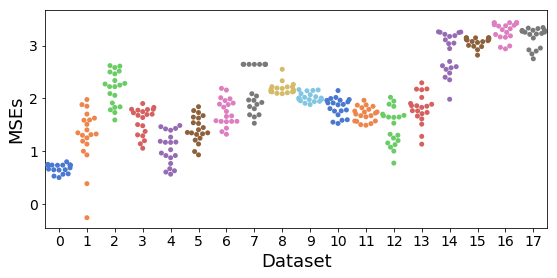

In [183]:
plotting.plt_mses_swarm(mses_M2b_hog1, save_fig='')

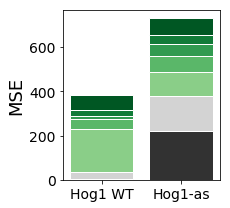

In [184]:
plotting.plt_mses(mses_M2b_hog1, (1,1, 0, 0, 0,0), size=(3,3), ptpD=False ,save_fig=model_folder+sim_id+'fit_mses')

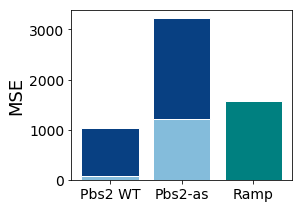

In [185]:
plotting.plt_mses(mses_M2b_hog1, (0,0, 1, 1, 1, 1), size=(4,3), ptpD=False ,save_fig=model_folder+sim_id+'predicted_mses')

$K_{M4}$  $k_3$       0.784701
$k_3$     $K_{M4}$    0.784701
$K_{M3}$  $k_3$       0.800286
$k_3$     $K_{M3}$    0.800286
          $k_4$       0.890703
$k_4$     $k_3$       0.890703
$k_6$     $K_{M6}$    0.940430
$K_{M6}$  $k_6$       0.940430
$K_{M2}$  $s_1$       0.984597
$s_1$     $K_{M2}$    0.984597
dtype: float64


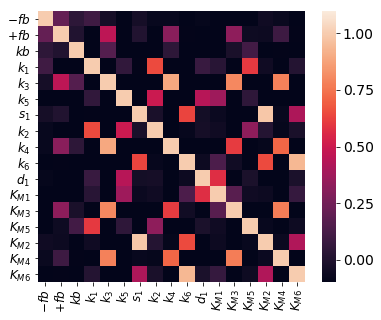

In [186]:
plotting.plt_corr(labelnames, df_top_params, save_fig=model_folder+sim_id+'corr')

### Save data

In [143]:
# save_sim_data(select_top_M4, doses, 2, path='C:/Users/sksuzuki/Documents/Research/figures/paper1/unsorted/', sim_name='M4_t100a', t100a=True)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [151]:
# save_sim_data(select_top_M4, doses, 2, path='C:/Users/sksuzuki/Documents/Research/figures/paper1/unsorted/', sim_name='M4_ramp', ramp=True)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


##  191014_kb_M2b.py

**Notes** 

- saved as the wrong date - 191010 should be 191014

### Inputs

In [227]:
folder = 'C:/Users/sksuzuki/Desktop/killdevil/runs_for_paper/191010_kb_M2b/'


model_folder = 'M2b/'
sim_id = 'M2b_f-all_'

### Gather simulated data

In [228]:
idx_top_M2b_all, top_params_M2b_all, top, plt_top, new_params, params_from_file, mse_M2b_all, last_mses_M2b_all = model_supp.gather_simulated_data(folder, gen, runs, 0.01)
df_top_params = pd.DataFrame(top_params_M2b_all)
df_top_params.columns = labelnames
df_top_params_log = df_top_params.apply(np.log10)
df_top_params_log_M_M2b_all = df_top_params_log.melt(var_name='param', value_name='vals')

Number of runs collected: 871
Best MSE: 1744.527510836566
Mean MSE of top 5%: 2004.505122774074


### Plot

In [229]:
select_top_M2b_all = top_params_M2b_all.copy()
# select_top_M2_all = np.concatenate((select_top_[:7], select_top_M4[8:11]))

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

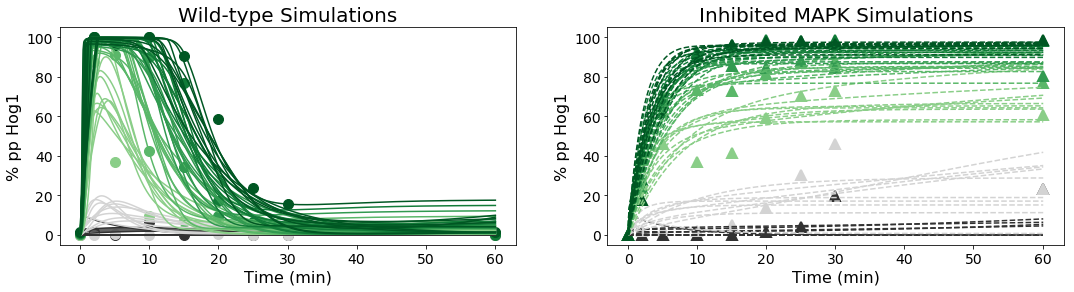

In [230]:
plotting.plt_param_behaviors(M2b_fxns, select_top_M2b_all, 10, params_constants, initials,  doses, time, 2, mapk_wt_data, mapk_t100a_data, mapk_time, save_fig=model_folder+sim_id+'hog1')
# plt.savefig("C:/Users/sksuzuki/Documents/Research/figures/simulations/hog1.png",dpi=150,bbox_inches='tight')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

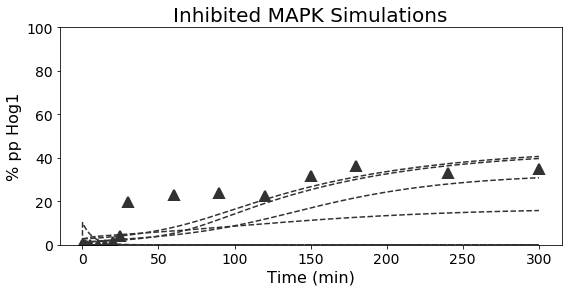

In [231]:
mapk_time_t100a_long = [0, 2, 5, 10, 15, 20, 25, 30, 60, 90, 120, 150, 180, 240, 300]

plotting.plt_t100a_long(M2b_fxns, select_top_M2b_all, 10, params_constants, initials, mapk_data_t100a_long[0], mapk_time_t100a_long, save_fig=model_folder+sim_id+'t100a_long')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

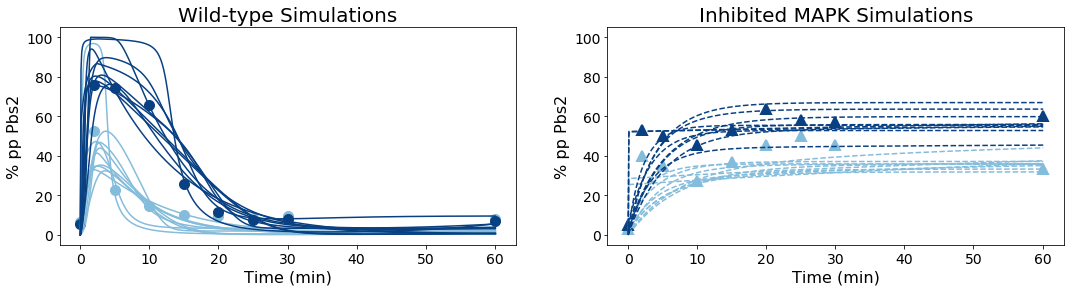

In [232]:
plotting.plt_param_behaviors(M2b_fxns, select_top_M2b_all, 10, params_constants, initials,  map2k_doses, time, 1, map2k_wt_data, map2k_t100a_data, mapk_time, save_fig=model_folder+sim_id+'pbs2')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

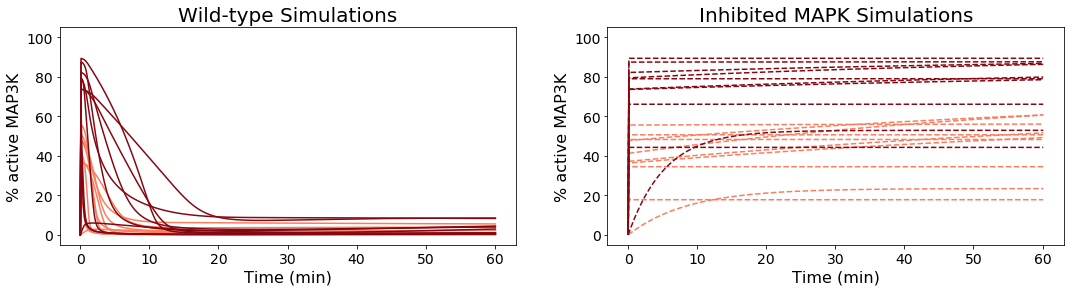

In [233]:
plotting.plt_param_behaviors(M2b_fxns, select_top_M2b_all, 10, params_constants, initials,  map2k_doses, time, 0, save_fig=model_folder+sim_id+'MAP3K')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

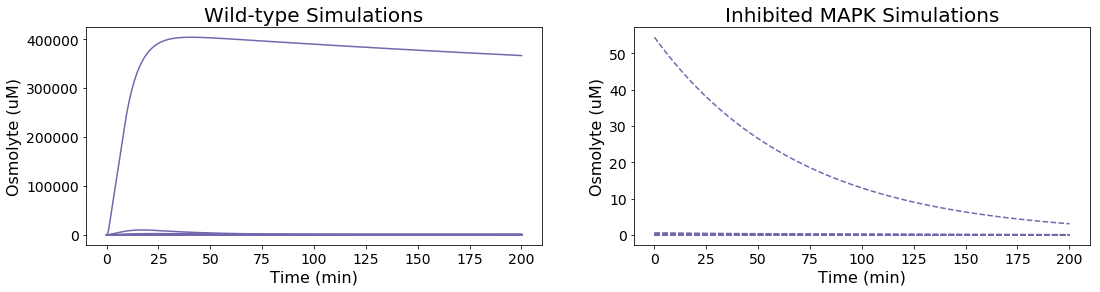

In [234]:
plotting.plt_param_behaviors(M2b_fxns, select_top_M2b_all, 10, params_constants, initials,  [350000], time, 3, save_fig=model_folder+sim_id+'Osmolytes')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


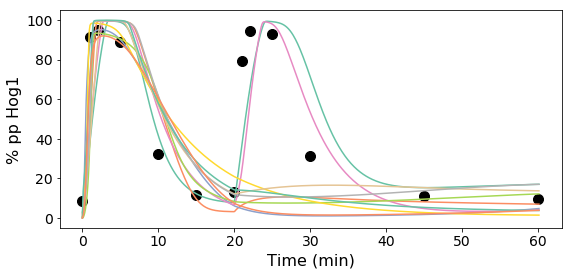

In [236]:
plotting.plt_ramp_behaviors(M2b_fxns, select_top_M2b_all, 10, params_constants, initials, time, 2, hog1_ramp_data, mapk_ramp_time, save_fig=model_folder+sim_id+'ramp')

<Figure size 720x576 with 0 Axes>

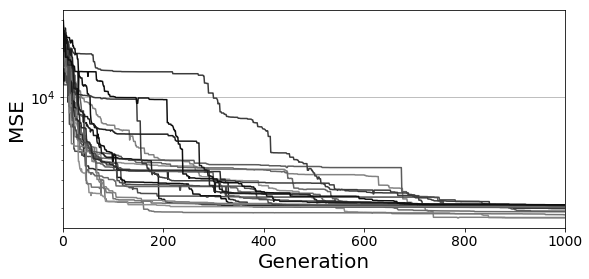

In [238]:
plotting.plt_mses_gen(gen,mse_M2b_all, idx_top_M2b_all, save_fig=model_folder+sim_id+'mses')

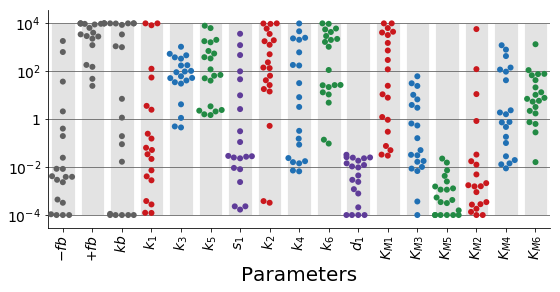

In [239]:
plotting.plt_param_ranges(labelnames, 'M2a', dims, df_top_params_log_M_M2b_all, save_fig=model_folder+sim_id+'params')

In [241]:
mses_M2b_all = model_supp.get_mse_stats(M2b_fxns, top_params_M2b_all, params_constants, initials, ptpD=False)
mses_M2b_all.head()

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


0          1           2          3          4          5   \
0  7.618702  43.263333  280.128107  93.676552  74.355104  97.029488   
1  5.474878  66.558104  312.233759  42.188438   9.271242  64.680830   
2  5.474917  52.016095  139.486739  68.388006  32.499497  52.438736   
3  4.987860  59.535458  361.110490  64.853336  38.192607  77.918778   
4  5.474404  51.469186  235.726912  54.103408  12.091512  32.661336   

           6           7           8           9          10          11  \
0   72.008157   46.664153  131.526475  106.244386  32.413389  135.049876   
1  175.950954   45.571257  189.975578  113.955453  34.630616   72.539318   
2   80.140058  441.707534  165.017623   78.732464  69.272358   76.593193   
3   93.736986   59.809851  120.089190   84.898763  43.671374   63.851526   
4  102.911192  441.700232  127.913562   91.735418  90.323245   41.027700   

           12          13          14          15          16           17  
0  133.927454  278.238348   60.105686   91.525194   25.563375   608.196523  
1   85.774514  188.079347   58.914191   96.142126   65.604571  1743.764121  
2   12.014440   63.897543   57.259717  203.270857  143.580443  1856.170699  
3   38.074610  122.322485  241.265728  130.833668   23.180656   620.600064  
4   33.662878  142.323832   55.074683  211.299081  117.413462  1844.310886

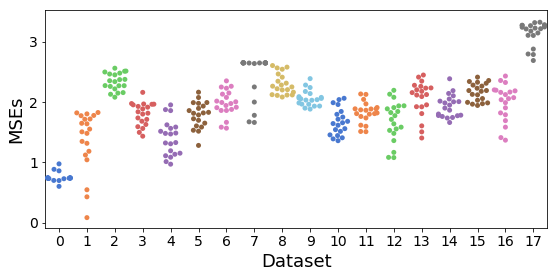

In [242]:
plotting.plt_mses_swarm(mses_M2b_all, save_fig='')

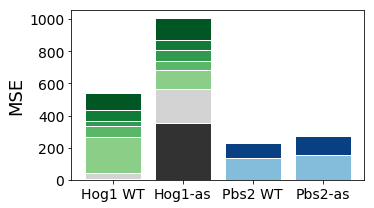

In [243]:
plotting.plt_mses(mses_M2b_all, (1,1, 1, 1, 0,0), size=(5,3), ptpD=False ,save_fig=model_folder+sim_id+'fit_mses')

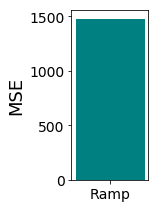

In [247]:
plotting.plt_mses(mses_M2b_all, (0,0, 0, 0, 1, 1), size=(2,3), ptpD=False ,save_fig=model_folder+sim_id+'predicted_mses')

$+ fb$    $k_3$       0.576308
$k_3$     $+ fb$      0.576308
$k_1$     $K_{M1}$    0.599241
$K_{M1}$  $k_1$       0.599241
$K_{M6}$  $k_6$       0.617703
$k_6$     $K_{M6}$    0.617703
$K_{M2}$  $k_4$       0.853115
$k_4$     $K_{M2}$    0.853115
$s_1$     $- fb$      0.994196
$- fb$    $s_1$       0.994196
dtype: float64


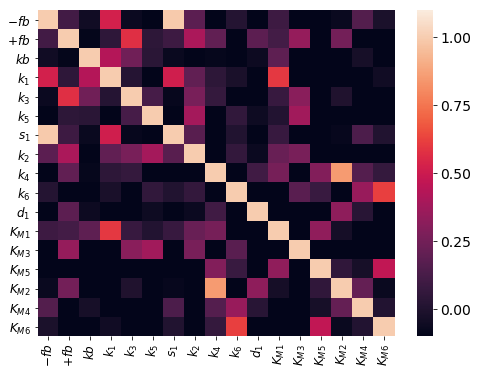

In [246]:
plotting.plt_corr(labelnames, df_top_params, save_fig=model_folder+sim_id+'corr')

### Save data

In [143]:
# save_sim_data(select_top_M4, doses, 2, path='C:/Users/sksuzuki/Documents/Research/figures/paper1/unsorted/', sim_name='M4_t100a', t100a=True)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [151]:
# save_sim_data(select_top_M4, doses, 2, path='C:/Users/sksuzuki/Documents/Research/figures/paper1/unsorted/', sim_name='M4_ramp', ramp=True)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


# M2c

##  191004_kb_M2c_hog1.py

**Notes** 
- M4 model - mutual inhibition model, though i named the files M3. 

### Inputs

In [187]:
folder = 'C:/Users/sksuzuki/Desktop/killdevil/runs_for_paper/191004_kb_M2c_hog1/'

diff = np.asarray(maximums)-np.asarray(minimums)
dims = (diff, minimums)




# mapk_time_t100a_long = [0, 2, 5, 10, 15, 20, 25, 30, 60, 90, 120, 150, 180, 240, 300]

# labels = ['MAP3K','MAP2K','MAPK','gly', 'PTP']

M2c_fxns = model.Model(model.M2c, model.simulate_t100a_experiment_M2a)

model_folder = 'M2c/'
sim_id = 'M2c_f-hog1_'

### Gather simulated data

In [189]:
idx_top_M2c_hog1, top_params_M2c_hog1, top, plt_top, new_params, params_from_file, mse_M2c_hog1, last_mses_M2c_hog1 = model_supp.gather_simulated_data(folder, gen, runs, 0.01)
df_top_params = pd.DataFrame(top_params_M2c_hog1)
df_top_params.columns = labelnames
df_top_params_log = df_top_params.apply(np.log10)
df_top_params_log_M_M2c_hog1 = df_top_params_log.melt(var_name='param', value_name='vals')

Number of runs collected: 1999
Best MSE: 822.3971558904741
Mean MSE of top 5%: 1138.6109021396176


### Plot

In [190]:
select_top_M2c_hog1 = top_params_M2c_hog1.copy()
# select_top_M2_all = np.concatenate((select_top_[:7], select_top_M4[8:11]))

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

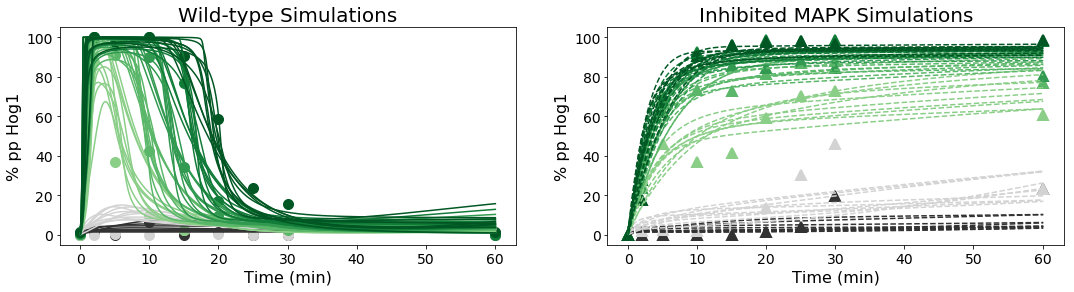

In [191]:
plotting.plt_param_behaviors(M2c_fxns, select_top_M2c_hog1, 10, params_constants, initials,  doses, time, 2, mapk_wt_data, mapk_t100a_data, mapk_time, save_fig=model_folder+sim_id+'hog1')
# plt.savefig("C:/Users/sksuzuki/Documents/Research/figures/simulations/hog1.png",dpi=150,bbox_inches='tight')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

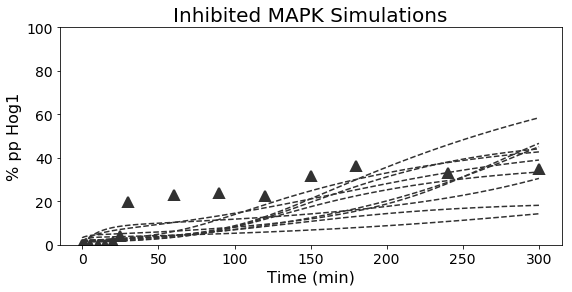

In [192]:
mapk_time_t100a_long = [0, 2, 5, 10, 15, 20, 25, 30, 60, 90, 120, 150, 180, 240, 300]

plotting.plt_t100a_long(M2c_fxns, select_top_M2c_hog1, 10, params_constants, initials, mapk_data_t100a_long[0], mapk_time_t100a_long, save_fig=model_folder+sim_id+'t100a_long')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

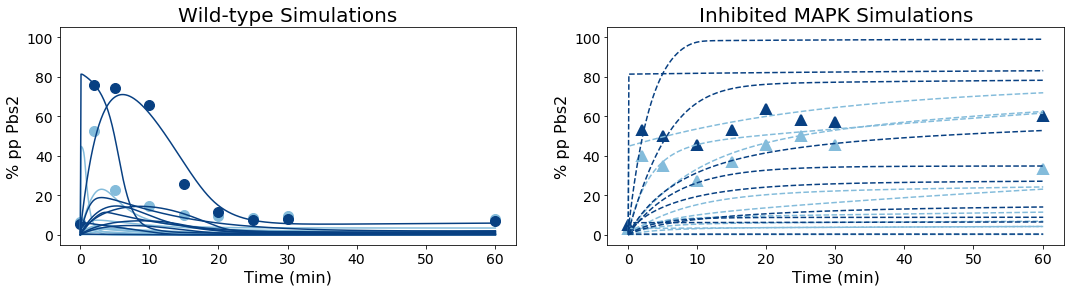

In [193]:
plotting.plt_param_behaviors(M2c_fxns, select_top_M2c_hog1, 10, params_constants, initials,  map2k_doses, time, 1, map2k_wt_data, map2k_t100a_data, mapk_time, save_fig=model_folder+sim_id+'pbs2')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

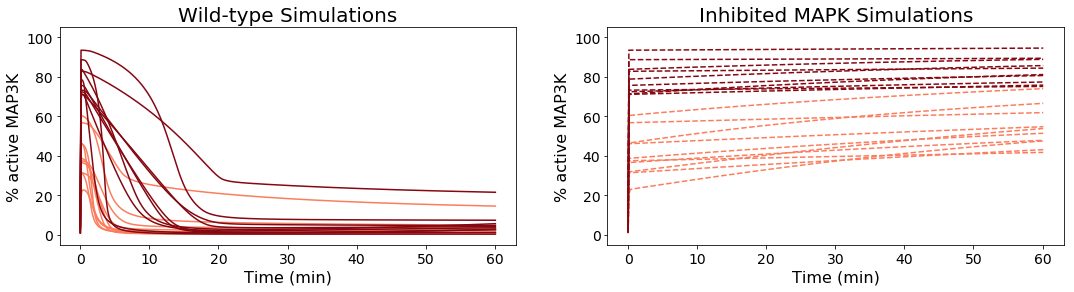

In [194]:
plotting.plt_param_behaviors(M2c_fxns, select_top_M2c_hog1, 10, params_constants, initials,  map2k_doses, time, 0, save_fig=model_folder+sim_id+'MAP3K')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

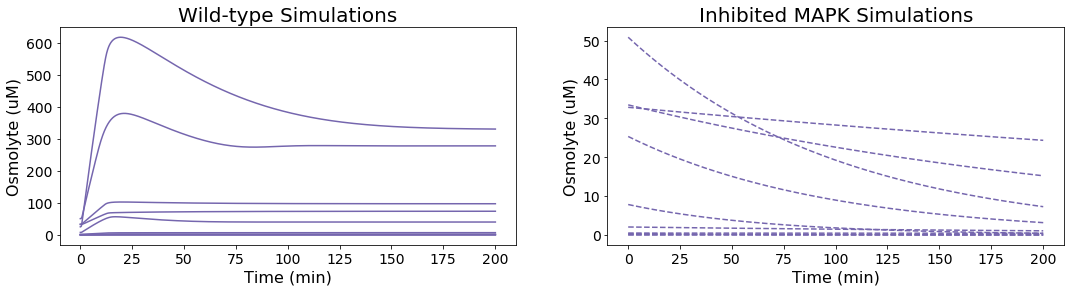

In [195]:
plotting.plt_param_behaviors(M2c_fxns, select_top_M2c_hog1, 10, params_constants, initials,  [350000], time, 3, save_fig=model_folder+sim_id+'Osmolytes')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


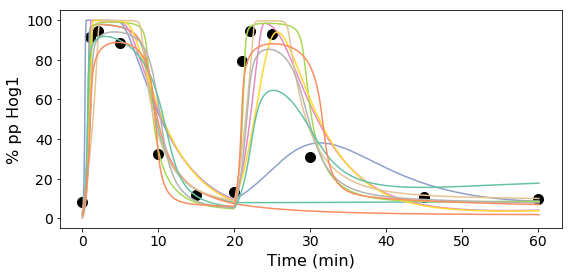

In [197]:
plotting.plt_ramp_behaviors(M2c_fxns, select_top_M2c_hog1, 10, params_constants, initials, time, 2, hog1_ramp_data, mapk_ramp_time, save_fig=model_folder+sim_id+'ramp')

<Figure size 720x576 with 0 Axes>

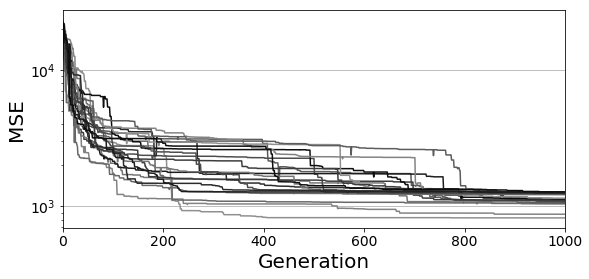

In [199]:
plotting.plt_mses_gen(gen,mse_M2c_hog1, idx_top_M2c_hog1, save_fig=model_folder+sim_id+'mses')

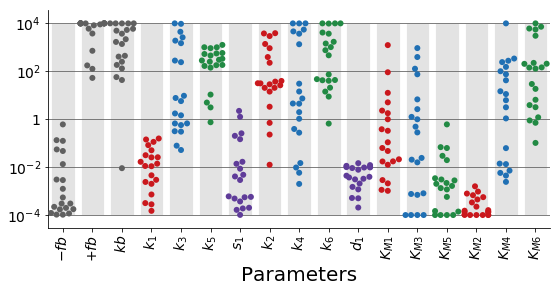

In [200]:
plotting.plt_param_ranges(labelnames, 'M2a', dims, df_top_params_log_M_M2c_hog1, save_fig=model_folder+sim_id+'params')

In [201]:
mses_M2c_hog1 = model_supp.get_mse_stats(M2c_fxns, top_params_M2c_hog1, params_constants, initials, ptpD=False)
mses_M2c_hog1.head()

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


0          1           2          3          4          5   \
0  11.508969  60.009986   82.053837  11.021983   8.038939   4.647568   
1  19.396893  48.078233   59.752409  13.573431   4.565292   6.822862   
2   5.441254  35.976841  162.960385  45.548648  25.778408  67.848802   
3   4.745791  36.327594  339.866149  48.889810  14.203478  49.727345   
4   5.720111  24.451006  109.321016  17.773275  38.530835  26.735085   

          6           7           8           9           10         11  \
0  89.084674   54.129054  117.527848  144.540318  117.923966  65.621401   
1  85.291570  103.000417  137.156330  124.897315  115.866548  79.982967   
2  64.609815   97.157506  205.788696  129.365393   44.429159  53.131941   
3  35.747450  101.109913  121.272792   93.256695   50.476289  43.964804   
4  93.676695  126.241066  166.758316   96.179181   44.984029  64.751593   

          12          13           14           15           16           17  
0  23.727401   32.560757  1087.890644   226.719432   339.190842  1589.472803  
1  46.347422   30.462730  1411.679574   494.237595   734.814108  1782.476751  
2  40.589864   63.026062   589.795862   398.904304   672.007998  1265.889887  
3  33.685916   77.278949  1661.045624  1167.141735  2141.099725   526.060222  
4  70.610165  176.068142   114.988702   189.693416  1318.117133   169.661941

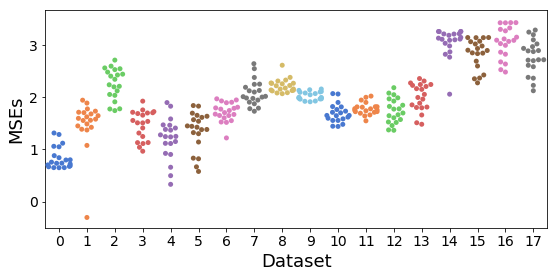

In [202]:
plotting.plt_mses_swarm(mses_M2c_hog1, save_fig='')

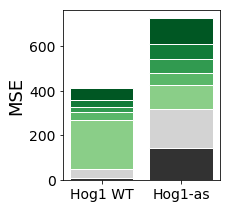

In [203]:
plotting.plt_mses(mses_M2c_hog1, (1,1, 0, 0, 0,0), size=(3,3), ptpD=False ,save_fig=model_folder+sim_id+'fit_mses')

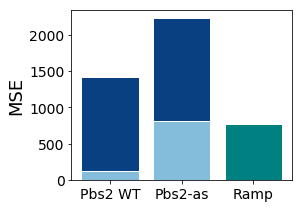

In [204]:
plotting.plt_mses(mses_M2c_hog1, (0,0, 1, 1, 1, 1), size=(4,3), ptpD=False ,save_fig=model_folder+sim_id+'predicted_mses')

$+ fb$    $k_5$       0.605463
$k_5$     $+ fb$      0.605463
$- fb$    $s_1$       0.629005
$s_1$     $- fb$      0.629005
$k_6$     $k_2$       0.792034
$k_2$     $k_6$       0.792034
          $K_{M2}$    0.814501
$K_{M2}$  $k_2$       0.814501
$k_1$     $kb$        0.827684
$kb$      $k_1$       0.827684
dtype: float64


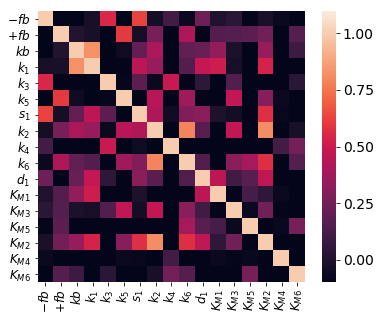

In [205]:
plotting.plt_corr(labelnames, df_top_params, save_fig=model_folder+sim_id+'corr')

### Save data

In [143]:
# save_sim_data(select_top_M4, doses, 2, path='C:/Users/sksuzuki/Documents/Research/figures/paper1/unsorted/', sim_name='M4_t100a', t100a=True)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [151]:
# save_sim_data(select_top_M4, doses, 2, path='C:/Users/sksuzuki/Documents/Research/figures/paper1/unsorted/', sim_name='M4_ramp', ramp=True)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


##  191010_kb_M2c.py

**Notes** 

### Inputs

In [249]:
folder = 'C:/Users/sksuzuki/Desktop/killdevil/runs_for_paper/191010_kb_M2c/'

M2c_fxns = model.Model(model.M2c, model.simulate_t100a_experiment_M2a)

model_folder = 'M2c/'
sim_id = 'M2c_f-all_'

### Gather simulated data

In [250]:
idx_top_M2c_all, top_params_M2c_all, top, plt_top, new_params, params_from_file, mse_M2c_all, last_mses_M2c_all = model_supp.gather_simulated_data(folder, gen, runs, 0.01)
df_top_params = pd.DataFrame(top_params_M2c_all)
df_top_params.columns = labelnames
df_top_params_log = df_top_params.apply(np.log10)
df_top_params_log_M_M2c_all = df_top_params_log.melt(var_name='param', value_name='vals')

Number of runs collected: 1236
Best MSE: 1802.850666359431
Mean MSE of top 5%: 2099.9020130241124


### Plot

In [251]:
select_top_M2c_all = top_params_M2c_all.copy()
# select_top_M2_all = np.concatenate((select_top_[:7], select_top_M4[8:11]))

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


<Figure size 720x576 with 0 Axes>

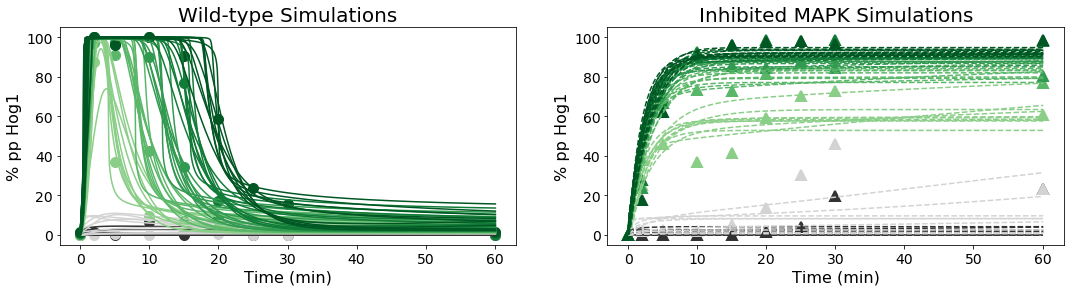

In [252]:
plotting.plt_param_behaviors(M2c_fxns, select_top_M2c_all, 10, params_constants, initials,  doses, time, 2, mapk_wt_data, mapk_t100a_data, mapk_time, save_fig=model_folder+sim_id+'hog1')
# plt.savefig("C:/Users/sksuzuki/Documents/Research/figures/simulations/hog1.png",dpi=150,bbox_inches='tight')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

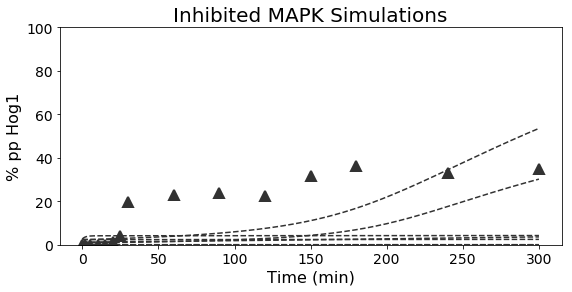

In [253]:
mapk_time_t100a_long = [0, 2, 5, 10, 15, 20, 25, 30, 60, 90, 120, 150, 180, 240, 300]

plotting.plt_t100a_long(M2c_fxns, select_top_M2c_all, 10, params_constants, initials, mapk_data_t100a_long[0], mapk_time_t100a_long, save_fig=model_folder+sim_id+'t100a_long')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

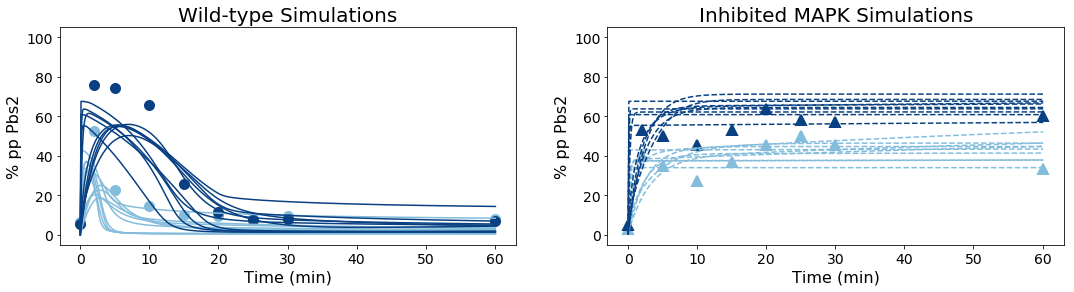

In [254]:
plotting.plt_param_behaviors(M2c_fxns, select_top_M2c_all, 10, params_constants, initials,  map2k_doses, time, 1, map2k_wt_data, map2k_t100a_data, mapk_time, save_fig=model_folder+sim_id+'pbs2')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

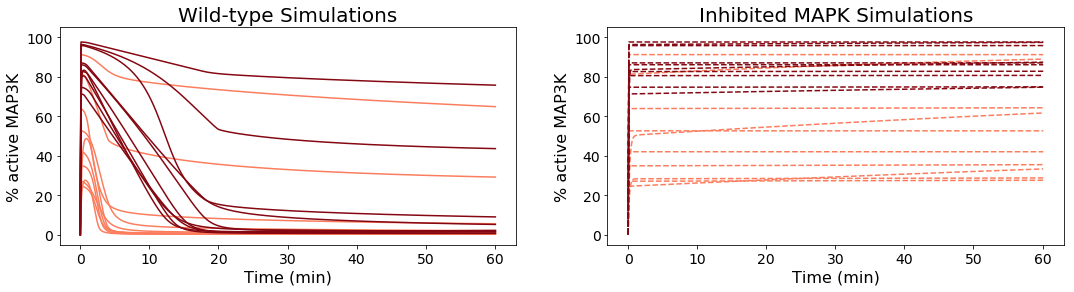

In [255]:
plotting.plt_param_behaviors(M2c_fxns, select_top_M2c_all, 10, params_constants, initials,  map2k_doses, time, 0, save_fig=model_folder+sim_id+'MAP3K')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

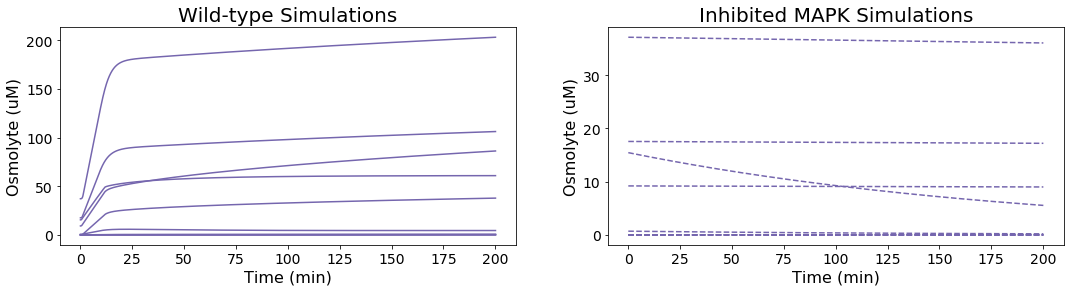

In [256]:
plotting.plt_param_behaviors(M2c_fxns, select_top_M2c_all, 10, params_constants, initials,  [350000], time, 3, save_fig=model_folder+sim_id+'Osmolytes')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


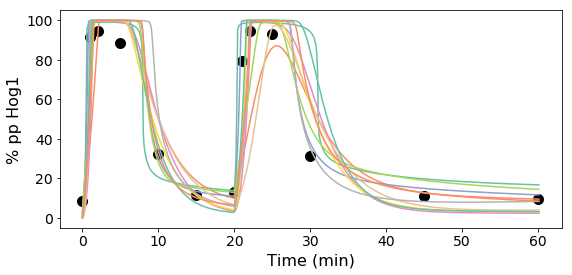

In [258]:
plotting.plt_ramp_behaviors(M2c_fxns, select_top_M2c_all, 10, params_constants, initials, time, 2, hog1_ramp_data, mapk_ramp_time, save_fig=model_folder+sim_id+'ramp')

<Figure size 720x576 with 0 Axes>

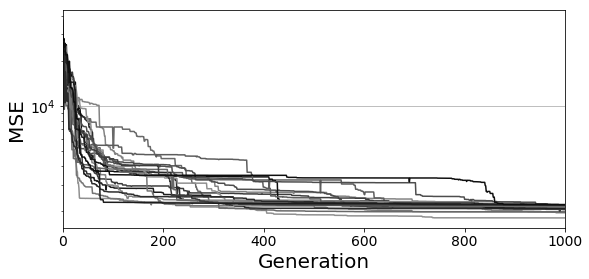

In [260]:
plotting.plt_mses_gen(gen,mse_M2c_all, idx_top_M2c_all, save_fig=model_folder+sim_id+'mses')

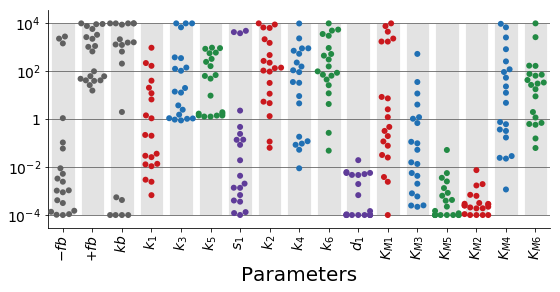

In [261]:
plotting.plt_param_ranges(labelnames, 'M2a', dims, df_top_params_log_M_M2c_all, save_fig=model_folder+sim_id+'params')

In [262]:
mses_M2c_all = model_supp.get_mse_stats(M2c_fxns, select_top_M2c_all, params_constants, initials, ptpD=False)
mses_M2c_all.head()

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)


0          1           2          3          4          5   \
0   6.327707  40.877438   59.798231  95.499557  70.366891  96.306700   
1   5.534601  27.561781  294.099727  39.898174  15.931014  46.837833   
2  10.893616  51.447398   39.158687  42.050799  46.036466  28.612286   
3   5.368290   0.545520  226.198711  20.764874   2.802941   7.564917   
4   5.504743  25.088604   52.986564  57.231944  58.705442  43.083612   

          6           7           8           9          10          11  \
0  34.701250  158.870469  182.457230  103.903730  39.306015  105.909857   
1  19.754180  372.745147  249.059839  120.230458  24.838937   70.975444   
2  60.365161  329.242968  232.090952  133.308478  36.706149  105.417528   
3  22.416850  440.125814  398.193038  106.193419  29.017014   44.797997   
4  61.562585  441.690234  252.115473  111.893430  28.251210   56.117547   

           12          13          14         15          16          17  
0  134.134135  221.117788  215.087919  88.403031   91.695696  373.687802  
1   86.698247  148.208198  125.196782  59.622825  166.555817  686.695537  
2  118.277882  193.938874  237.671333  68.276036   94.045124   62.694145  
3   68.675362  122.069233  202.002481  48.814457   73.325437  626.926895  
4   51.819562  105.141379  333.983526  85.420569  158.003739  331.578179

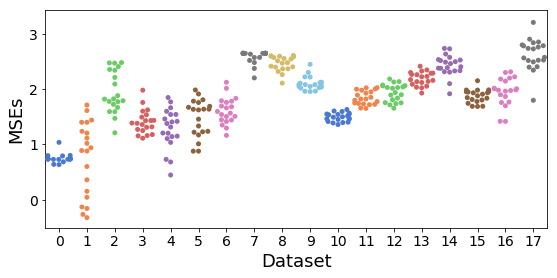

In [263]:
plotting.plt_mses_swarm(mses_M2c_all, save_fig='')

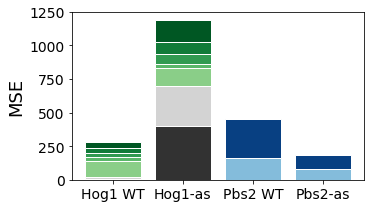

In [264]:
plotting.plt_mses(mses_M2c_all, (1,1, 1, 1, 0,0), size=(5,3), ptpD=False ,save_fig=model_folder+sim_id+'fit_mses')

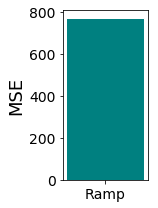

In [266]:
plotting.plt_mses(mses_M2c_hog1, (0,0, 0, 0, 1, 1), size=(2,3), ptpD=False ,save_fig=model_folder+sim_id+'predicted_mses')

$k_1$     $s_1$       0.594116
$s_1$     $k_1$       0.594116
$K_{M1}$  $kb$        0.657247
$kb$      $K_{M1}$    0.657247
$k_1$     $K_{M1}$    0.775277
$K_{M1}$  $k_1$       0.775277
$- fb$    $s_1$       0.973365
$s_1$     $- fb$      0.973365
$k_5$     $+ fb$      0.988809
$+ fb$    $k_5$       0.988809
dtype: float64


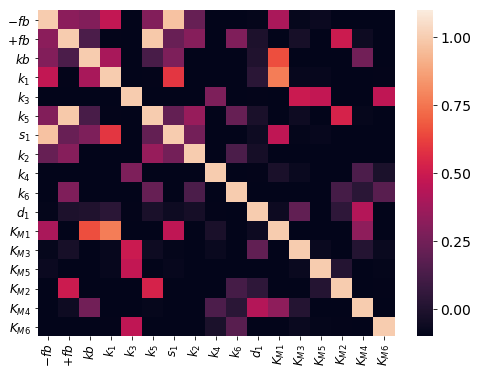

In [267]:
plotting.plt_corr(labelnames, df_top_params, save_fig=model_folder+sim_id+'corr')

### Save data

In [143]:
# save_sim_data(select_top_M4, doses, 2, path='C:/Users/sksuzuki/Documents/Research/figures/paper1/unsorted/', sim_name='M4_t100a', t100a=True)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [151]:
# save_sim_data(select_top_M4, doses, 2, path='C:/Users/sksuzuki/Documents/Research/figures/paper1/unsorted/', sim_name='M4_ramp', ramp=True)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


# Compare Models

In [40]:
def change_param(param_set, idx):
    param_sets = []
#     print(param_set[idx])
    for i in np.logspace(-4,4,8):
        new_param_set = param_set.copy()
#         print(i)
#         print(new_param_set[idx])
        new_param_set[idx] = new_param_set[idx]*i
#         print(new_param_set[idx])
        param_sets.append(new_param_set)
    return param_sets

In [165]:
b3 = change_param(best_fit, 0)
a1 = change_param(best_fit, 1)
a2 = change_param(best_fit, 2)
kb = change_param(best_fit, 3)
k1 = change_param(best_fit, 4)
k3 = change_param(best_fit, 5)
k5 = change_param(best_fit, 6)
s7 = change_param(best_fit, 7)
k9 = change_param(best_fit, 8)
k2 = change_param(best_fit, 9)
k4 = change_param(best_fit, 10)
d8 = change_param(best_fit, 11)
K1 = change_param(best_fit, 12)
K3 = change_param(best_fit, 13)
K5 = change_param(best_fit, 14)
K9 = change_param(best_fit, 15)
K2 = change_param(best_fit, 16)
K4 = change_param(best_fit, 17)
K6 = change_param(best_fit, 18)
K10 = change_param(best_fit, 19)
pPTP= change_param(best_fit, 20)

<Figure size 864x576 with 0 Axes>

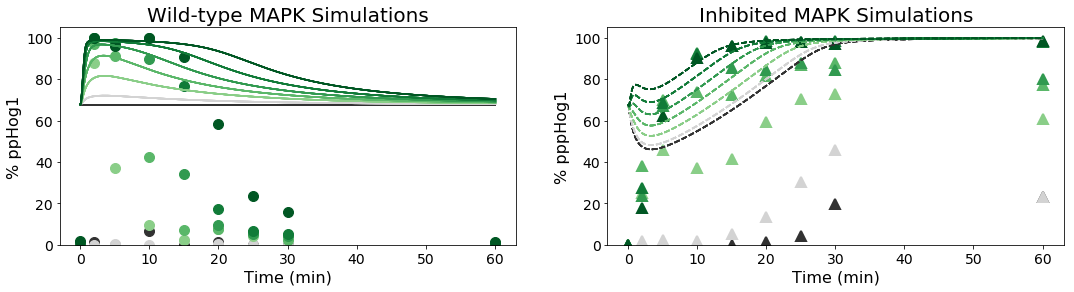

In [256]:
plt_param_behaviors(pPTP, 10, params_constants, initials, 5000, doses, time, 2, mapk_wt_data, mapk_t100a_data, mapk_time)

<Figure size 864x576 with 0 Axes>

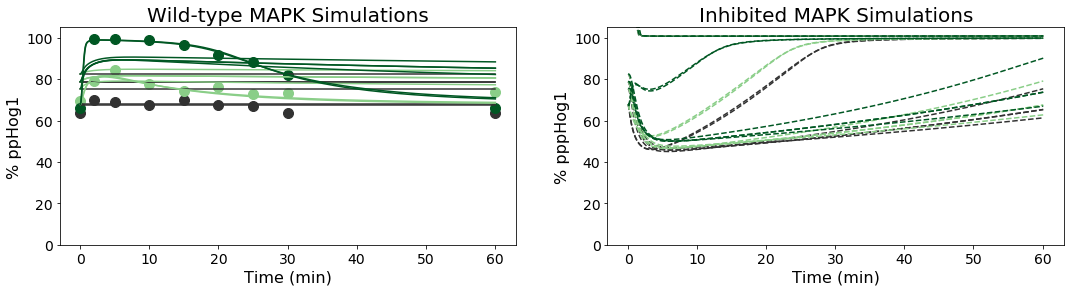

In [257]:
plt_param_behaviors_consts_diff(pPTP, 10, consts_diff, initials, 5000, [0]+map2k_doses, time, 2, mapk_ptp_data, None, mapk_time)

## Calculate Ttest

In [39]:
from scipy.stats import ttest_ind
ttest = ttest_ind(df_top_params_ptp23, df_df_top_params_all, axis=0)
print(ttest)

Ttest_indResult(statistic=array([ 2.39679427, -2.79229073, -1.32267715,  1.35465514, -0.54118825,
        1.7618635 , -1.96711273, -0.65253951, -2.92496233, -1.32407551,
        1.11084685,  3.27659218, -2.54644332, -0.51225341, -0.5430844 ,
       -0.64036423, -0.88305972, -0.81891478, -0.58938274,  5.35936213,
       13.22090904]), pvalue=array([1.73831097e-02, 5.69868390e-03, 1.87328616e-01, 1.76929721e-01,
       5.88930435e-01, 7.94939813e-02, 5.04386338e-02, 5.14740687e-01,
       3.80914011e-03, 1.86864583e-01, 2.67857974e-01, 1.22241783e-03,
       1.15725799e-02, 6.08992243e-01, 5.87626541e-01, 5.22608326e-01,
       3.78176751e-01, 4.13729348e-01, 5.56214849e-01, 2.11972735e-07,
       1.08039792e-29]))


Tukey's test (honing in on two comparisons of the group) for ANOVA (summary statistic comparing all of the groups) correcting for multiple testing https://cleverowl.uk/2015/07/01/using-one-way-anova-and-tukeys-test-to-compare-data-sets/

## Calculate score

In [290]:
hog1_doses = [0, 50000, 150000, 250000, 350000, 450000, 550000]
pbs2_doses = [150000, 550000]
ptp_doses = [0, 150000, 550000]

for params in top_params_a1_1D[:10]:
    print(scorefxn(initials, params_constants, params))

[0, 2, 5, 10, 15, 20, 25, 30, 60]
[0, 2, 5, 10, 15, 20, 25, 30, 60]
[0, 2, 5, 10, 15, 20, 25, 30, 60]
[0, 2, 5, 10, 15, 20, 25, 30, 60]
[0, 2, 5, 10, 15, 20, 25, 30, 60]
[0, 2, 5, 10, 15, 20, 25, 30, 60]
[0, 2, 5, 10, 15, 20, 25, 30, 60]
[0.0, 0.0, 0.0, 0.0, 0.0, 1.361472, 4.18506, 19.49207995, 23.08120093, 23.78618578, 22.3375094, 31.67199502, 36.30961501, 33.02963546, 34.87627365]


C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


ValueError: operands could not be broadcast together with shapes (9,) (15,) 